## Agência Nacional do Cinema - ANCINE

### Desafios e Oportunidades na Indústria Cinematográfica Brasileira

#### **Análise Exploratória de Dados**

Este projeto tem como objetivo realizar uma Análise Exploratória de Dados (EDA) sobre o conjunto de dados abertos ANCINE - Agência Nacional do Cinema. 

Neste estudo, foram explorados os dados referentes aos Agentes Econômicos cadastrados na ANCINE, assim como suas atividades, Investidores,  Obras cinematográficas, Projetos contratados e outros. 


---

## 0. Imports e Carregamento do Projeto

In [1]:
import math

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error as msqerr

from collections import Counter as co
from matplotlib import pyplot as plt, gridspec
from matplotlib import font_manager as fm
from wordcloud import WordCloud as wc
from v2_abrir_projeto import Projeto
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

pj = Projeto()
pj.abrir_projeto()


***Bem vindo(a) ao Projeto!***

Para ler documentação: "pj.doc.documentacao"



### 0.1  Exibição da Documentação basilar para navegação.

In [2]:
pj.doc.documentacao()

**** DOCUMENTAÇÃO DO PROJETO ****
***Agência Nacional do Cinema***

Cada Arquivo CSV contém uma variável raíz e um 
número de referência para variáveis específicas.
*
*
Para chamar variável no Jupyter Notebook digite: "df." + variável
*
Para chamar variável específica digite: "df." + "variável_especifica" + número
*
*
Nome arquivo CSV | Nome variável raíz | Número variável específica
-
Agentes Econômicos Regulares = agnts_economicos = 1  
Atividades Economicas dos Agentes Regulares = atividade_economicas_agnts = 2 
Projetos Renúncia Fiscal = proj_renuncia_fiscal = 3  
Obras não Publicitárias Brasileiras - Fomento Indireto = obras_n_publi_fomento_direto =  4 
Obras não Publcitárias Brasileiras - Investimento FSA = obras_n_publi_investimento_fsa =  5 
Processos de Prestação de contas = processos_prestacao_contas = 6  
Investidores de projetos de Renúncia Fiscal = investidores_proj_renuncia_fiscal = 7   
Produtoras Independentes = produtoras_independentes = 8 
Produtores de obra não Publi

### 0.2 Função para carregar variáveis no ambiente local do projeto

In [3]:
#Carregar variáveis no ambiente local (Método para economizar tempo de digitação)
def carregar():
        
        from pandas import DataFrame as pd

        global agnts_economicos
        agnts_economicos = pd(pj.df.agnts_economicos)
        global atividade_economicas_agnts
        atividade_economicas_agnts = pd(pj.df.atividade_economicas_agnts)
        global proj_renuncia_fiscal
        proj_renuncia_fiscal = pd(pj.df.proj_renuncia_fiscal)
        global obras_n_publi_fomento_direto
        obras_n_publi_fomento_direto = pd(pj.df.obras_n_publi_fomento_direto)
        global obras_n_publi_investimento_fsa
        obras_n_publi_investimento_fsa = pd(pj.df.obras_n_publi_investimento_fsa)
        global processos_prestacao_contas
        processos_prestacao_contas = pd(pj.df.processos_prestacao_contas)
        global investidores_proj_renuncia_fiscal
        investidores_proj_renuncia_fiscal = pd(pj.df.investidores_proj_renuncia_fiscal)
        global produtoras_independentes
        produtoras_independentes = pd(pj.df.produtoras_independentes)
        global produtores_obras_n_publi
        produtores_obras_n_publi = pd(pj.df.produtores_obras_n_publi)
        global proj_fsa_desembolso
        proj_fsa_desembolso = pd(pj.df.proj_fsa_desembolso)
        global relacao_grupos_economicos
        relacao_grupos_economicos = pd(pj.df.relacao_grupos_economicos)
        global salas_complexos
        salas_complexos = pd(pj.df.salas_complexos)    
carregar()

---

## 1. Carregamento de dados


*Por conta do modelo de POO que foi aplicado nesse projeto, os dados foram previamente pré-processados, ou seja, não vamos encontrar tabelas com valores nulos ou colunas com tipos de dados equivocados. Para conhecer a documentação desse processo, clique [aqui](https://github.com/fonsecadados/AgenciaNacionalDoCinema_ANCINE/blob/main/processamento_dados.py).*

### 1.2 Unificar Tabelas

Para maior eficiência no código, vamos unificar as tabelas "Agentes Econômicos" e "Atividade dos Agentes Econômicos"

1.2.1 Agentes Econômicos x Atividade dos Agentes Econômicos x Produtores Independentes

In [4]:
def unificar_tabelas_agentes(): #Criando Dataframe merged Agentes Economicos Regulares x Atividades Economicas dos Agentes

    agnts_atividades_economicas = pd.merge(agnts_economicos, atividade_economicas_agnts, on='REGISTRO_ANCINE', how='inner') #Merge tabelas agnt econômicos e atividades
    agnts_atividades_economicas = agnts_atividades_economicas[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL_x', 'CNPJ_x', #selecionando colunas
        'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA', 'ATIVIDADE_ECONOMICA','CLASSIFICACAO_ATIVIDADE', 'BRASILEIRO_INDEPENDENTE']]

    agnts_atividades_economicas.rename(columns={'RAZAO_SOCIAL_x' : 'RAZAO_SOCIAL', 'CNPJ_x' : 'CNPJ'}, inplace=True) #corrigindo nomes das colunas

    agnts_atividades_economicas = agnts_atividades_economicas[agnts_atividades_economicas['CLASSIFICACAO_ATIVIDADE'] == 1] # filtrando a colunaClassificação de atividades para deixar apenas as principais, evitando agentes duplicados

    #Produtoras Independentes
    global produtoras_independentes
    global agnts_tabela_unificada
    global tabela_unificada_atividades_economicas

    produtoras_independentes = produtoras_independentes[['REGISTRO_ANCINE', 'CLASSIFICACAO_NIVEL_PRODUTORA']] # selecionando colunas - Produtoras Independentes
    agnts_tabela_unificada = pd.DataFrame(pd.merge(agnts_atividades_economicas, produtoras_independentes, how='outer', on='REGISTRO_ANCINE')) #Merge tabelas
    agnts_tabela_unificada.dropna(subset='CLASSIFICACAO_NIVEL_PRODUTORA', inplace=True)

    agnts_tabela_unificada = agnts_tabela_unificada.drop_duplicates(subset=['CNPJ'])
unificar_tabelas_agentes()

1.2.3 FSA Desembolso / Renúncia Fiscal x Agentes Econômicos (tabela unificada)

In [5]:
produtoras_proj_renun_fiscal = proj_renuncia_fiscal.copy()
produtoras_proj_renun_fiscal = agnts_tabela_unificada.merge(produtoras_proj_renun_fiscal, left_on='CNPJ', right_on='CNPJ_PROPONENTE')
produtoras_proj_renun_fiscal = produtoras_proj_renun_fiscal[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL', 'CNPJ',
       'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA',
       'ATIVIDADE_ECONOMICA', 'CLASSIFICACAO_NIVEL_PRODUTORA', 'TITULO_PROJETO', 'LEI_8313', 'ART1',
       'ART1A', 'ART3', 'ART3A', 'ART39', 'FUNCINES', 'TOTAL_CAPTADO',
       'DT_APROVACAO_CAPTACAO', 'DT_1_LIBERACAO']]


produtoras_proj_fsa_desembolso = proj_fsa_desembolso.copy()
produtoras_proj_fsa_desembolso = agnts_tabela_unificada.merge(produtoras_proj_fsa_desembolso, left_on='CNPJ', right_on='CNPJ_PROPONENTE')
produtoras_proj_fsa_desembolso = produtoras_proj_fsa_desembolso[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL', 'CNPJ',
       'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA',
       'ATIVIDADE_ECONOMICA', 'CLASSIFICACAO_NIVEL_PRODUTORA', 'TITULO_PROJETO',
       'CHAMADA_PUBLICA', 'ANO_CHAMADA_PUBLICA', 'DT_PUBLICACAO_CONTRATO_DOU',
       'VL_CONTRATO_DOU', 'DT_PRIMEIRO_DESEMBOLSO', 'VL_TOTAL_LIBERADO']]


# FSA - DESEMBOLSO
fsa_desembolso = produtoras_proj_fsa_desembolso.copy()
fsa_desembolso['ANO_CHAMADA_PUBLICA'] = fsa_desembolso['ANO_CHAMADA_PUBLICA'].str.split('/').str[-1] 
fsa_desembolso['ANO_CHAMADA_PUBLICA'] = pd.to_numeric(fsa_desembolso['ANO_CHAMADA_PUBLICA'])

data_ficticia = pd.to_datetime('1900-12-31')
fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'].fillna(data_ficticia, inplace=True)
fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = pd.to_datetime(fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'])

fsa_desembolso['DT_PUBLICACAO_CONTRATO_DOU'] = pd.to_datetime(fsa_desembolso['DT_PUBLICACAO_CONTRATO_DOU'])

fsa_desembolso['VL_CONTRATO_DOU'] = fsa_desembolso['VL_CONTRATO_DOU'].str.replace(',', '.').astype(float)

fsa_desembolso['VL_TOTAL_LIBERADO'] = fsa_desembolso['VL_TOTAL_LIBERADO'].str.replace(',', '.').astype(float)
fsa_desembolso['VL_TOTAL_LIBERADO'].fillna(0, inplace=True)

fsa_desembolso['CLASSIFICACAO_NIVEL_PRODUTORA'] = fsa_desembolso['CLASSIFICACAO_NIVEL_PRODUTORA'].astype(int)

fsa_desembolso['TITULO_PROJETO'].fillna('Sem Título', inplace=True)

# RENÚNICA FISCAL
renuncia_fiscal = produtoras_proj_renun_fiscal.copy()

renuncia_fiscal['CLASSIFICACAO_NIVEL_PRODUTORA'] = renuncia_fiscal['CLASSIFICACAO_NIVEL_PRODUTORA'].astype(int)

def float_int(coluna):
    zero = '0,0'

    renuncia_fiscal[coluna] = renuncia_fiscal[coluna].str.replace(',', '.').astype(float)

float_int('LEI_8313')
float_int('ART1')
float_int('ART1A')
float_int('ART3')
float_int('ART3A')
float_int('ART39')
float_int('FUNCINES')
float_int('TOTAL_CAPTADO')

### 1.3 Visualizar Tabela

In [6]:
#Função que retorne o perfil de um banco de dados
def perfil_banco_dados(df):
    duplicado = df['CNPJ'].duplicated()
    soma_duplicado = duplicado.sum()
    
    print('Raio-x')
    print()
    print(df.info())
    print('----')
    
    if soma_duplicado > 0:
        print(f'A coluna CNPJ possui {soma_duplicado} valores duplicados.')
    else:
        print('A coluna CNPJ não possui valores duplicados.')
    
    print('----')
    return df.sample(5)

1.3.2 Agentes (tabela unificada)

In [7]:
perfil_banco_dados(agnts_tabela_unificada)

Raio-x

<class 'pandas.core.frame.DataFrame'>
Index: 11354 entries, 0 to 18571
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                11354 non-null  int64         
 1   DATA_REGISTRO                  11354 non-null  datetime64[ns]
 2   RAZAO_SOCIAL                   11354 non-null  object        
 3   CNPJ                           11354 non-null  object        
 4   DATA_CONSTITUICAO              11354 non-null  datetime64[ns]
 5   UF                             11354 non-null  object        
 6   MUNICIPIO                      11354 non-null  object        
 7   NATUREZA_JURIDICA              11354 non-null  object        
 8   ATIVIDADE_ECONOMICA            11354 non-null  object        
 9   CLASSIFICACAO_ATIVIDADE        11354 non-null  int64         
 10  BRASILEIRO_INDEPENDENTE        11354 non-null  bool          
 11  CLASSIFICACA

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_ATIVIDADE,BRASILEIRO_INDEPENDENTE,CLASSIFICACAO_NIVEL_PRODUTORA
6670,38926,2018-02-27,LIZIANE BORTOLATTO-ME,21.206.023/0001-27,2014-10-09,SC,ITAJAÍ,Empresário (Individual),Produção de espetáculos de dança,1,True,1.0
5402,31333,2015-11-03,DMITRIK FILMES LTDA - ME,20.629.221/0001-30,2014-07-14,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0
12638,49097,2021-07-26,GASA FILMES LTDA,42.419.667/0001-73,2021-06-10,MG,NOVA LIMA,Sociedade Empresária Limitada,Atividades de gravação de som e de edição de m...,1,True,1.0
18219,56801,2023-12-07,BROADCAST NETWORK COMUNICAÇÃO LTDA,06.016.347/0001-09,2003-11-14,SP,SÃO PAULO,Sociedade Empresária Limitada,Agências de publicidade,1,True,1.0
17576,56022,2023-10-26,ELLAH FILMES LTDA,52.212.223/0001-16,2023-09-18,SP,OSASCO,Sociedade Empresária Limitada,Produção de filmes para publicidade,1,True,1.0


1.3.3 FSA - Desembolso

In [8]:
perfil_banco_dados(fsa_desembolso)

Raio-x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3353 entries, 0 to 3352
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                3353 non-null   int64         
 1   DATA_REGISTRO                  3353 non-null   datetime64[ns]
 2   RAZAO_SOCIAL                   3353 non-null   object        
 3   CNPJ                           3353 non-null   object        
 4   DATA_CONSTITUICAO              3353 non-null   datetime64[ns]
 5   UF                             3353 non-null   object        
 6   MUNICIPIO                      3353 non-null   object        
 7   NATUREZA_JURIDICA              3353 non-null   object        
 8   ATIVIDADE_ECONOMICA            3353 non-null   object        
 9   CLASSIFICACAO_NIVEL_PRODUTORA  3353 non-null   int32         
 10  TITULO_PROJETO                 3353 non-null   object        
 11  CHAMADA_P

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_NIVEL_PRODUTORA,TITULO_PROJETO,CHAMADA_PUBLICA,ANO_CHAMADA_PUBLICA,DT_PUBLICACAO_CONTRATO_DOU,VL_CONTRATO_DOU,DT_PRIMEIRO_DESEMBOLSO,VL_TOTAL_LIBERADO
983,2102,2004-11-16,ATC ENTRETENIMENTOS LTDA.,02.008.424/0001-28,1997-08-04,CE,AQUIRAZ,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",4,DENTE POR DENTE,PRODAV 06,2016,2018-07-26,1350000.0,2018-07-31,1350000.0
3118,29813,2015-05-04,FABIANA BRAZ MORON,18.303.581/0001-04,2013-06-14,BA,SALVADOR,Empresário (Individual),"Artes cênicas, espetáculos e atividades comple...",1,CONEXÕES E HASHTAGS,PRODAV 02 - PROJETO DERIVADO,2016,2019-04-10,390000.0,2019-04-29,390000.0
173,232,2002-06-20,KINOFILMES PRODUÇÕES ARTÍSTICAS E CINEMATOGRÁF...,01.464.291/0001-31,1996-09-25,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",4,O CORPO É NOSSO,COMERCIALIZAÇÃO EM CINEMA,2018,2019-07-05,99930.0,2019-07-18,99930.0
3298,35924,2017-03-23,DENISE MONTEIRO DE OLIVEIRA,23.150.369/0001-86,2015-08-26,BA,SALVADOR,Empresário (Individual),Filmagem de festas e eventos,1,TERRAS QUE LIBERTAM - HISTÓRIAS DOS CUPERTINOS,PRODAV 02 - PROJETO DERIVADO,2016,2019-10-30,207790.0,2019-11-07,207790.0
2299,18130,2010-12-27,LEBEN 108 PRODUTORA DE FILMES LTDA,12.709.052/0001-10,2010-04-06,MG,BELO HORIZONTE,Sociedade Empresária Limitada,Estúdios cinematográficos,1,NXIAMU,SAV/MINC 01,2016,2018-03-21,1250000.0,2018-04-09,1250000.0


1.3.4 Renúncia Fiscal

In [9]:
perfil_banco_dados(renuncia_fiscal)

Raio-x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                2609 non-null   int64         
 1   DATA_REGISTRO                  2609 non-null   datetime64[ns]
 2   RAZAO_SOCIAL                   2609 non-null   object        
 3   CNPJ                           2609 non-null   object        
 4   DATA_CONSTITUICAO              2609 non-null   datetime64[ns]
 5   UF                             2609 non-null   object        
 6   MUNICIPIO                      2609 non-null   object        
 7   NATUREZA_JURIDICA              2609 non-null   object        
 8   ATIVIDADE_ECONOMICA            2609 non-null   object        
 9   CLASSIFICACAO_NIVEL_PRODUTORA  2609 non-null   int32         
 10  TITULO_PROJETO                 2609 non-null   object        
 11  LEI_8313 

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_NIVEL_PRODUTORA,...,LEI_8313,ART1,ART1A,ART3,ART3A,ART39,FUNCINES,TOTAL_CAPTADO,DT_APROVACAO_CAPTACAO,DT_1_LIBERACAO
2602,45227,2020-03-02,KILOMBA PRODUCOES LTDA,33.163.124/0001-47,2019-03-27,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,...,0.0000,0.0,0.0,0.00,675000.0,0.0,0.0,6.750000e+05,2022-07-28,2023-02-07
98,43,2003-03-24,FILMES DO EQUADOR LTDA.,73.619.637/0001-34,1993-10-22,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",5,...,920000.0018,2846000.0,0.0,498065.37,0.0,0.0,0.0,4.264065e+06,1997-12-05,1998-06-08
123,53,2003-02-26,GIROS PROJETOS AUDIOVISUAIS LTDA,04.661.796/0001-84,2001-08-31,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",5,...,0.0000,0.0,350000.0,0.00,0.0,0.0,0.0,3.500000e+05,2018-06-27,2020-08-27
1929,12902,2007-09-12,MEDIALAND PRODUÇÃO E COMUNICAÇÃO LTDA,08.346.159/0001-74,2006-09-20,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",5,...,0.0000,0.0,0.0,0.00,0.0,1155700.0,0.0,1.155700e+06,2011-06-29,2011-09-08
2066,14339,2008-09-11,PAULO AUGUSTO P. CASÉ LTDA,09.558.964/0001-24,2008-03-25,RJ,RIO DE JANEIRO,Sociedade Simples Limitada,"Atividades de produção cinematográfica, de víd...",5,...,0.0000,0.0,0.0,587682.83,1500000.0,0.0,0.0,2.087683e+06,2010-08-16,2010-09-22


### 1.4 Dimensões e NA

In [10]:
def dimensao_na(df, df_name=None):

    unique_values = df.apply(lambda x: x.nunique())
    null_values = df.isnull().sum()

    nome_df = pd.DataFrame({
        'Quantidade de Valores' : unique_values.values,
        'Tipo da Coluna' : df.dtypes,
        'Quantidade de Nulos' : null_values.values   
    }).reset_index()

    print(f"DataFrame name: {df_name}")
    return nome_df

1.4.2 Agentes (tabela unificada)

In [11]:
dimensao_na(agnts_tabela_unificada, "Agentes Econômicos - Tabela Unificada")

DataFrame name: Agentes Econômicos - Tabela Unificada


,index,Quantidade de Valores,Tipo da Coluna,Quantidade de Nulos
0,REGISTRO_ANCINE,11354,int64,0
1,DATA_REGISTRO,3838,datetime64[ns],0
2,RAZAO_SOCIAL,11343,object,0
3,CNPJ,11354,object,0
4,DATA_CONSTITUICAO,5651,datetime64[ns],0
5,UF,27,object,0
6,MUNICIPIO,681,object,0
7,NATUREZA_JURIDICA,10,object,0
8,ATIVIDADE_ECONOMICA,186,object,0
9,CLASSIFICACAO_ATIVIDADE,1,int64,0


1.4.3 FSA Desembolso

In [12]:
dimensao_na(fsa_desembolso, "FSA- Desembolso")

DataFrame name: FSA- Desembolso


,index,Quantidade de Valores,Tipo da Coluna,Quantidade de Nulos
0,REGISTRO_ANCINE,1122,int64,0
1,DATA_REGISTRO,939,datetime64[ns],0
2,RAZAO_SOCIAL,1122,object,0
3,CNPJ,1122,object,0
4,DATA_CONSTITUICAO,1037,datetime64[ns],0
5,UF,27,object,0
6,MUNICIPIO,109,object,0
7,NATUREZA_JURIDICA,8,object,0
8,ATIVIDADE_ECONOMICA,38,object,0
9,CLASSIFICACAO_NIVEL_PRODUTORA,5,int32,0


1.4.4 Renúncia Fiscal

In [13]:
dimensao_na(renuncia_fiscal, "Renúncia Fiscal")

DataFrame name: Renúncia Fiscal


,index,Quantidade de Valores,Tipo da Coluna,Quantidade de Nulos
0,REGISTRO_ANCINE,755,int64,0
1,DATA_REGISTRO,629,datetime64[ns],0
2,RAZAO_SOCIAL,755,object,0
3,CNPJ,755,object,0
4,DATA_CONSTITUICAO,726,datetime64[ns],0
5,UF,19,object,0
6,MUNICIPIO,59,object,0
7,NATUREZA_JURIDICA,8,object,0
8,ATIVIDADE_ECONOMICA,21,object,0
9,CLASSIFICACAO_NIVEL_PRODUTORA,5,int32,0


---

## 2. Análise Exploratória

#### Atividades Econômicas dos Agentes

2.1 Sumário e Nuvem de Palavras

In [14]:
#Além de dados estatísticos sobre as atividades econômicas, vamos extrair nuvens de palavras encontradas nas 
#atividades mais recorrentes e menos recorrentes das produtoras com classificação de nível.

#Criar lista de atividades econômicas
lista_atividades = agnts_tabela_unificada['ATIVIDADE_ECONOMICA'].tolist()

palavra = []
for atividade in lista_atividades:
    palavra.extend(atividade.split())

#Excluir outliers 
lista_atividades_counter = co(lista_atividades)
palavra_counter = co(palavra) #Método para contar as palavras
print(f'Número de Atividades Econômicas distintas: {len(lista_atividades_counter)}')

atividade_economica_contagem = pd.DataFrame(agnts_tabela_unificada['ATIVIDADE_ECONOMICA'].value_counts().head(10))
atividade_economica_contagem

Número de Atividades Econômicas distintas: 186


,count
ATIVIDADE_ECONOMICA,
"Atividades de produção cinematográfica, de vídeos e de programas de televisão não especificadas anteriormente",5488
Produção de filmes para publicidade,1337
Estúdios cinematográficos,676
"Artes cênicas, espetáculos e atividades complementares não especificados anteriormente",462
Agências de publicidade,364
"Atividades de pós-produção cinematográfica, de vídeos e de programas de televisão não especificadas anteriormente",363
"Serviços de organização de feiras, congressos, exposições e festas",227
"Atividades de produção de fotografias, exceto aérea e submarina",199
Produção teatral,194


Nuvem de palavras com as 50 mais recorrentes entre as Atividades Econômicas


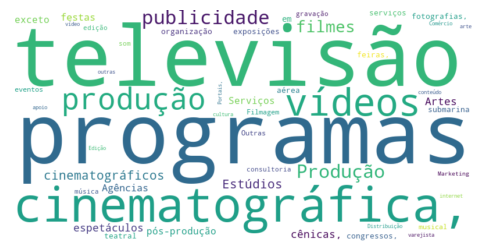

Nuvem de palavras com as 400 menos recorrentes entre as Atividades Econômicas


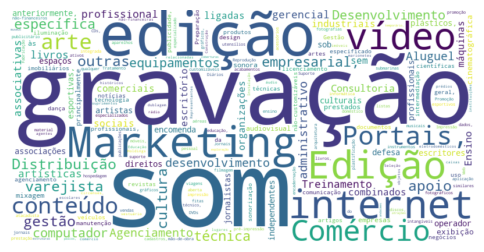

In [15]:
#Lista de palavras da tabela de produtoras independentes para excluir
palavras_excluir = ['de', 'e', 'não', 'anteriormente', 'Atividades', 'especificadas', 'para', 'atividades',\
                     'especificados', 'complementares', 'à', 'na', 'direto', 'outros', 'informação', 'provedores']
palavras_frequencia = [palavra for palavra in palavra if palavra not in palavras_excluir]
# palavras_frequencia = co(palavras_frequencia)
# Suponha que você tenha a lista de palavras filtradas armazenada em 'palavras_frequencia'
palavras_frequencia = [palavra for palavra in palavra if palavra not in palavras_excluir]

# Crie um objeto Counter com as palavras filtradas
contador_palavras = co(palavras_frequencia)

# Obtenha as 25 palavras mais comuns
maior_frequencia = contador_palavras.most_common(50)
menor_frequencia = contador_palavras.most_common()[-399:]

# Converta as palavras e suas frequências em um dicionário
dic_palavras_maior_frequencia = dict(maior_frequencia)
dic_palavras_menor_frequencia = dict(menor_frequencia)

# Crie uma nuvem de palavras para as 25 palavras mais comuns
nuvem_palavras_maior_frequencia = wc(width=800, height=400, background_color='white').generate_from_frequencies(dic_palavras_maior_frequencia)

# Plote a nuvem de palavras para as 25 palavras mais comuns
print('Nuvem de palavras com as 50 mais recorrentes entre as Atividades Econômicas')
plt.figure(figsize=(6, 4))
plt.imshow(nuvem_palavras_maior_frequencia, interpolation='bilinear')
plt.axis('off')
plt.show()

# Crie uma nuvem de palavras para as 415 palavras menos comuns
nuvem_palavras_menor_frequencia = wc(width=800, height=400, background_color='white').generate_from_frequencies(dic_palavras_menor_frequencia)

# Plote a nuvem de palavras para as 415 palavras menos comuns
print('Nuvem de palavras com as 400 menos recorrentes entre as Atividades Econômicas')
plt.figure(figsize=(6, 4))
plt.imshow(nuvem_palavras_menor_frequencia, interpolation='bilinear')
plt.axis('off')
plt.show()

---

2.2 Distribuição dos Agentes Econômicos no País (Produtores Independentes)

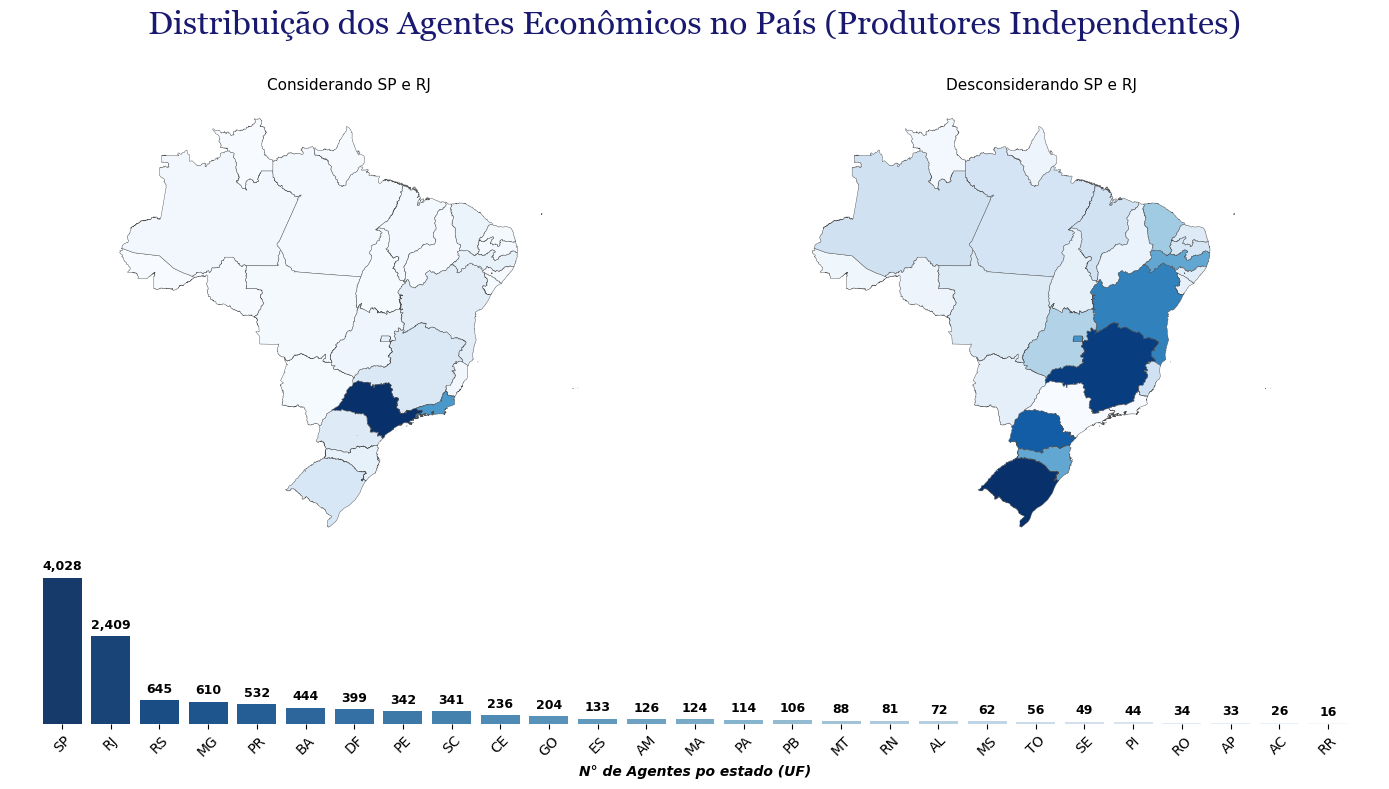

In [16]:
# Carregar mapa BR
brasil = gpd.read_file('C:\\Users\\syafo\\OneDrive\\Documentos\\GitHub\\AgenciaNacionalDoCinema_ANCINE\\geopandas\\BR_UF_2022.shp')

# Plot com todos os estados
totais_por_estado = agnts_tabela_unificada['UF'].value_counts().reset_index()
totais_por_estado.columns = ['UF', 'Total']

brasil = brasil.merge(totais_por_estado, left_on='SIGLA_UF', right_on='UF')

# Filtrar os dados excluindo SP e RJ
estados_sem_sp_rj = agnts_tabela_unificada[(agnts_tabela_unificada['UF'] != 'RJ') & (agnts_tabela_unificada['UF'] != 'SP')]
estados_count = estados_sem_sp_rj['UF'].value_counts().reset_index()
estados_count.columns = ['UF', 'Total']

# Adicionar linhas para SP e RJ com total zero
sp_row = pd.DataFrame({'UF': ['SP'], 'Total': [0]})
rj_row = pd.DataFrame({'UF': ['RJ'], 'Total': [0]})
estados_count = pd.concat([estados_count, sp_row, rj_row], ignore_index=True)

estados_count = estados_count.sort_values(by='UF')
estados_count = estados_count.rename(columns={'UF': 'UF_count', 'Total': 'Total_count'})
brasil_estados = brasil.merge(estados_count, left_on='SIGLA_UF', right_on='UF_count')

# Criar a figura
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[2, 2])
# Plotar mapa dos estados sem SP e RJ
ax1 = plt.subplot(gs[0,0])
brasil_estados.plot(column='Total', cmap='Blues', linewidth=0.3, ax=ax1, edgecolor='0.3', legend=False)
ax1.set_title('Considerando SP e RJ', fontsize=11, fontweight='light')
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Plotar mapa dos estados com SP e RJ
ax2 = plt.subplot(gs[0,1])
brasil_estados.plot(column='Total_count', cmap='Blues', linewidth=0.3, ax=ax2, edgecolor='0.3', legend=False)
ax2.set_title('Desconsiderando SP e RJ', fontsize=11, fontweight='light')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Plotar gráfico de barras
ax3 = plt.subplot(gs[1, :])
sns.countplot(data=agnts_tabela_unificada, x='UF', order=agnts_tabela_unificada['UF'].value_counts().index, palette='Blues_r', ax=ax3)
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 8), 
                   textcoords='offset points',
                   fontsize=9, fontweight='bold')
# ax3.set_title('Quantidade de Agentes Econômicos por Estado', fontsize=13, fontweight='medium')
ax3.set_xlabel('N° de Agentes po estado (UF)', fontsize=10, fontweight='bold', fontstyle='oblique')
ax3.set_ylabel(None)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, fontsize=10, fontweight='normal') 
ax3.set_yticks([])
ax3.margins(0.025)
plt.tight_layout()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}

plt.suptitle('Distribuição dos Agentes Econômicos no País (Produtores Independentes)', fontdict=fontprops, fontsize=24)
plt.subplots_adjust(top=0.87)
plt.show()


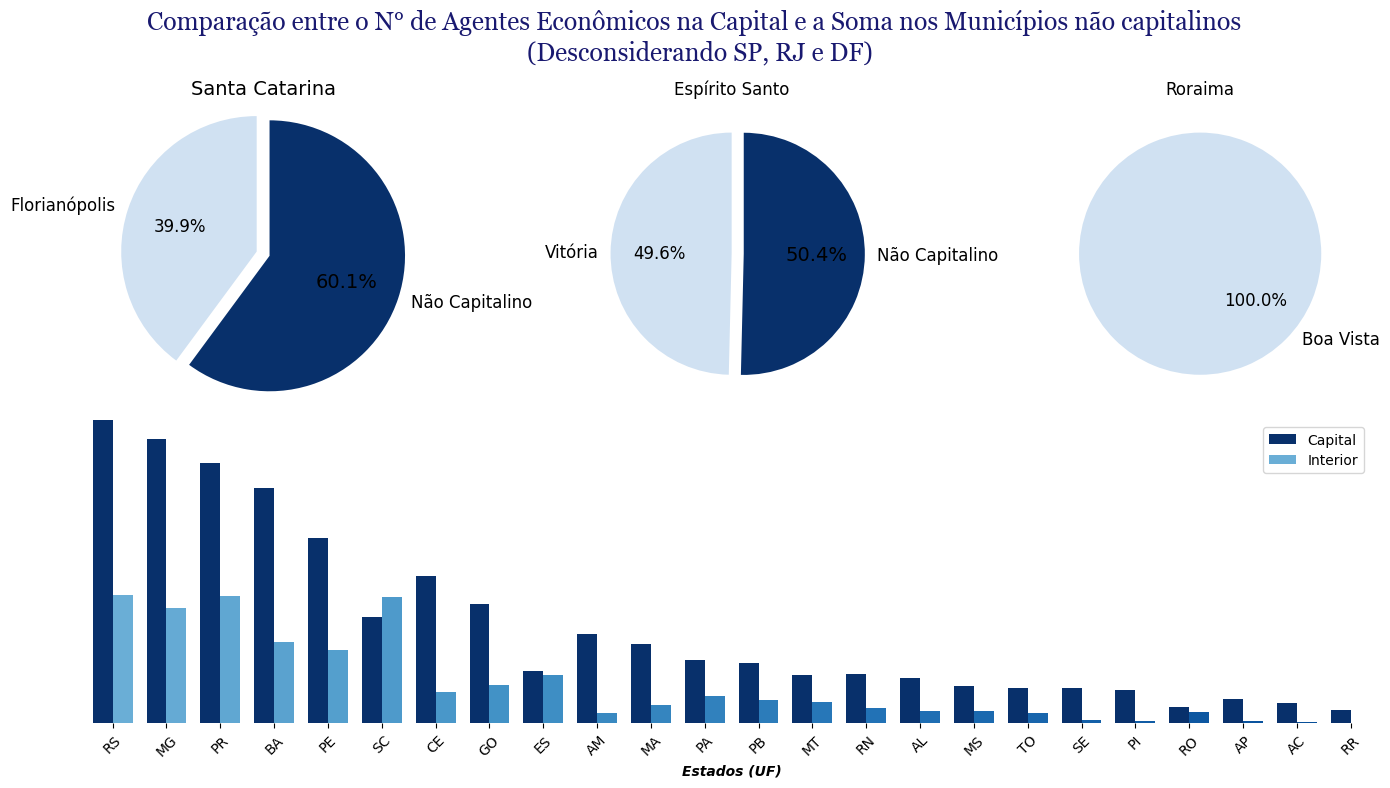

In [17]:
#Gráficos de Pizza
santa_catarina = agnts_tabela_unificada.query("UF == 'SC'")['MUNICIPIO'].value_counts()
roraima = agnts_tabela_unificada.query("UF == 'RR'")['MUNICIPIO'].value_counts()
espirito_santo = agnts_tabela_unificada.query("UF == 'ES'")['MUNICIPIO'].value_counts()

santa_catarina_interior = santa_catarina.sum() - santa_catarina.iloc[0]
roraima_interior = roraima.sum() - roraima.iloc[0]
espirito_santo_interior = espirito_santo.sum() - espirito_santo.iloc[0]

santa_catarina_pie = {'Florianópolis': 136,
                        'Não Capitalino' : 205}

roraima_pie = {'Boa Vista': 16}

espirito_santo_pie = {'Vitória' : 66,
                      'Não Capitalino' : 67}

cores_sc = plt.cm.Blues(np.linspace(0.2, 1, len(santa_catarina_pie)))
cores_es = plt.cm.Blues(np.linspace(0.2, 1, len(roraima_pie)))
cores_rr = plt.cm.Blues(np.linspace(0.2, 1, len(espirito_santo_pie)))

####

#Gráfico de Barras
#Função para comparar o número de Agentes Econômicos nas capitais e no interior dos UFs
def capital_vs_interior(uf, produtora_classificacao):
    separar_uf = produtora_classificacao[produtora_classificacao['UF'] == uf]
    capital = separar_uf['MUNICIPIO'].value_counts().head(1)
    interior = separar_uf['MUNICIPIO'].value_counts().head(15).sum() - capital 
    nome_capital = capital.index[0]
    capital.rename(index={nome_capital : 'Capital'}, inplace=True)
    interior.rename(index={nome_capital : 'Interior'}, inplace=True)
    return capital, interior

estados = [ 'RS', 'MG', 'PR', 'BA', 'PE', 'SC', 
           'CE', 'GO', 'ES', 'AM', 'MA', 'PA', 'PB', 'MT', 
           'RN', 'AL', 'MS', 'TO', 'SE', 'PI', 'RO', 'AP', 'AC', 'RR'] #Lista de UFs

capitais = []
interiores = [] #lista para armazenar os valores

for uf in estados: #Loop for sobre cada estado
    capital, interior = capital_vs_interior(uf, agnts_tabela_unificada)
    capitais.append(capital)
    interiores.append(interior)


#####
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 3], width_ratios=[3, 3, 3])


##########################################

# Pie - Santa Catarina
ax1 = plt.subplot(gs[0, 0])
wedges, texts, autotexts = ax1.pie(santa_catarina_pie.values(), labels=santa_catarina_pie.keys(), 
                                   colors=cores_sc, autopct='%1.1f%%', startangle=90, 
                                   explode=(0, 0.1), textprops={'fontsize': 12, 'fontweight': 'medium'})


autotexts[1].set_fontsize(14)
autotexts[1].set_fontweight('medium')
ax1.axis('equal')
ax1.grid(False)
ax1.set_title('Santa Catarina', fontsize=14, fontweight='medium')
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

#Pie - Espírito Santo
ax2 = plt.subplot(gs[0, 1])
wedges, texts, autotexts = ax2.pie(espirito_santo_pie.values(), labels=espirito_santo_pie.keys(), 
                                   colors=cores_sc, autopct='%1.1f%%', startangle=90, 
                                   explode=(0, 0.1), textprops={'fontsize': 12, 'fontweight': 'medium'})


autotexts[1].set_fontsize(14)
autotexts[1].set_fontweight('medium')
ax1.axis('equal')
ax1.grid(False)
ax2.set_title('Espírito Santo', fontsize=12, fontweight='medium')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

#Pie - Roraima
ax3 = plt.subplot(gs[0,2])
ax3.pie(roraima_pie.values(), labels=roraima_pie.keys(),colors=cores_rr,  
           autopct='%1.1f%%', startangle=140, shadow=False, textprops={'fontsize': 12, 'fontweight': 'medium'})
ax3.set_title('Roraima', fontsize=12, fontweight='medium')
ax3.set_xlabel(None)
ax3.set_ylabel(None)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)


#############
#Criação do Plot com 3 gráficos 
#Gráfico de barras       
bar_width = 0.37 #largura das barras
r1 = np.arange(len(estados)) #posição das barras
r2 = [x + bar_width for x in r1] #posição das barras
cores_int = plt.cm.Blues(np.linspace(0.5, 0.9, len(estados))) #definindo cores
cores_cap = plt.cm.Blues(np.linspace(1, 2, len(estados))) #definindo cores

ax4 = plt.subplot(gs[1, :])
# Plot das capitais
ax4 = plt.bar(r1, [c.values[0] for c in capitais], color=cores_cap, width=bar_width, label='Capital')

# Plot dos interiores
ax4 = plt.bar(r2, [i.values[0] for i in interiores], color=cores_int, width=bar_width, label='Interior')

ax4 = plt.xlabel('Estados (UF)', fontsize=10, fontweight='bold', fontstyle='oblique')
ax4 = plt.ylabel(None)
ax4 = plt.xticks([r + bar_width/2 for r in range(len(estados))], estados)  # Definindo os rótulos do eixo x como os estados
ax4 = plt.legend()
ax4 = plt.xticks(rotation=45, fontweight='medium')
ax4 = plt.yticks([])
ax4 = plt.margins(False)
ax4 = plt.box([])


fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
plt.suptitle('Comparação entre o N° de Agentes Econômicos na Capital e a Soma nos Municípios não capitalinos \n (Desconsiderando SP, RJ e DF)', fontdict=fontprops, fontsize=18)
plt.subplots_adjust(top=0.87)
plt.tight_layout()
plt.show()


2.3 Naturezas Jurídicas

In [18]:
#Naturezas Jurídicas
consultas = {
    'ltda': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Empresária Limitada'"),
    'mei': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresário (Individual)'"),
    'eireli_empresaria': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresa Individual de Responsabilidade Limitada (de Natureza Empresária)'"),
    'ss_limitada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Simples Limitada'"),
    'associacao_privada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Associação Privada'"),
    'eireli_simples': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresa Individual de Responsabilidade Limitada (de Natureza Simples)'"),
    'sa_fechada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Anônima Fechada'")
}

globals().update(consultas)

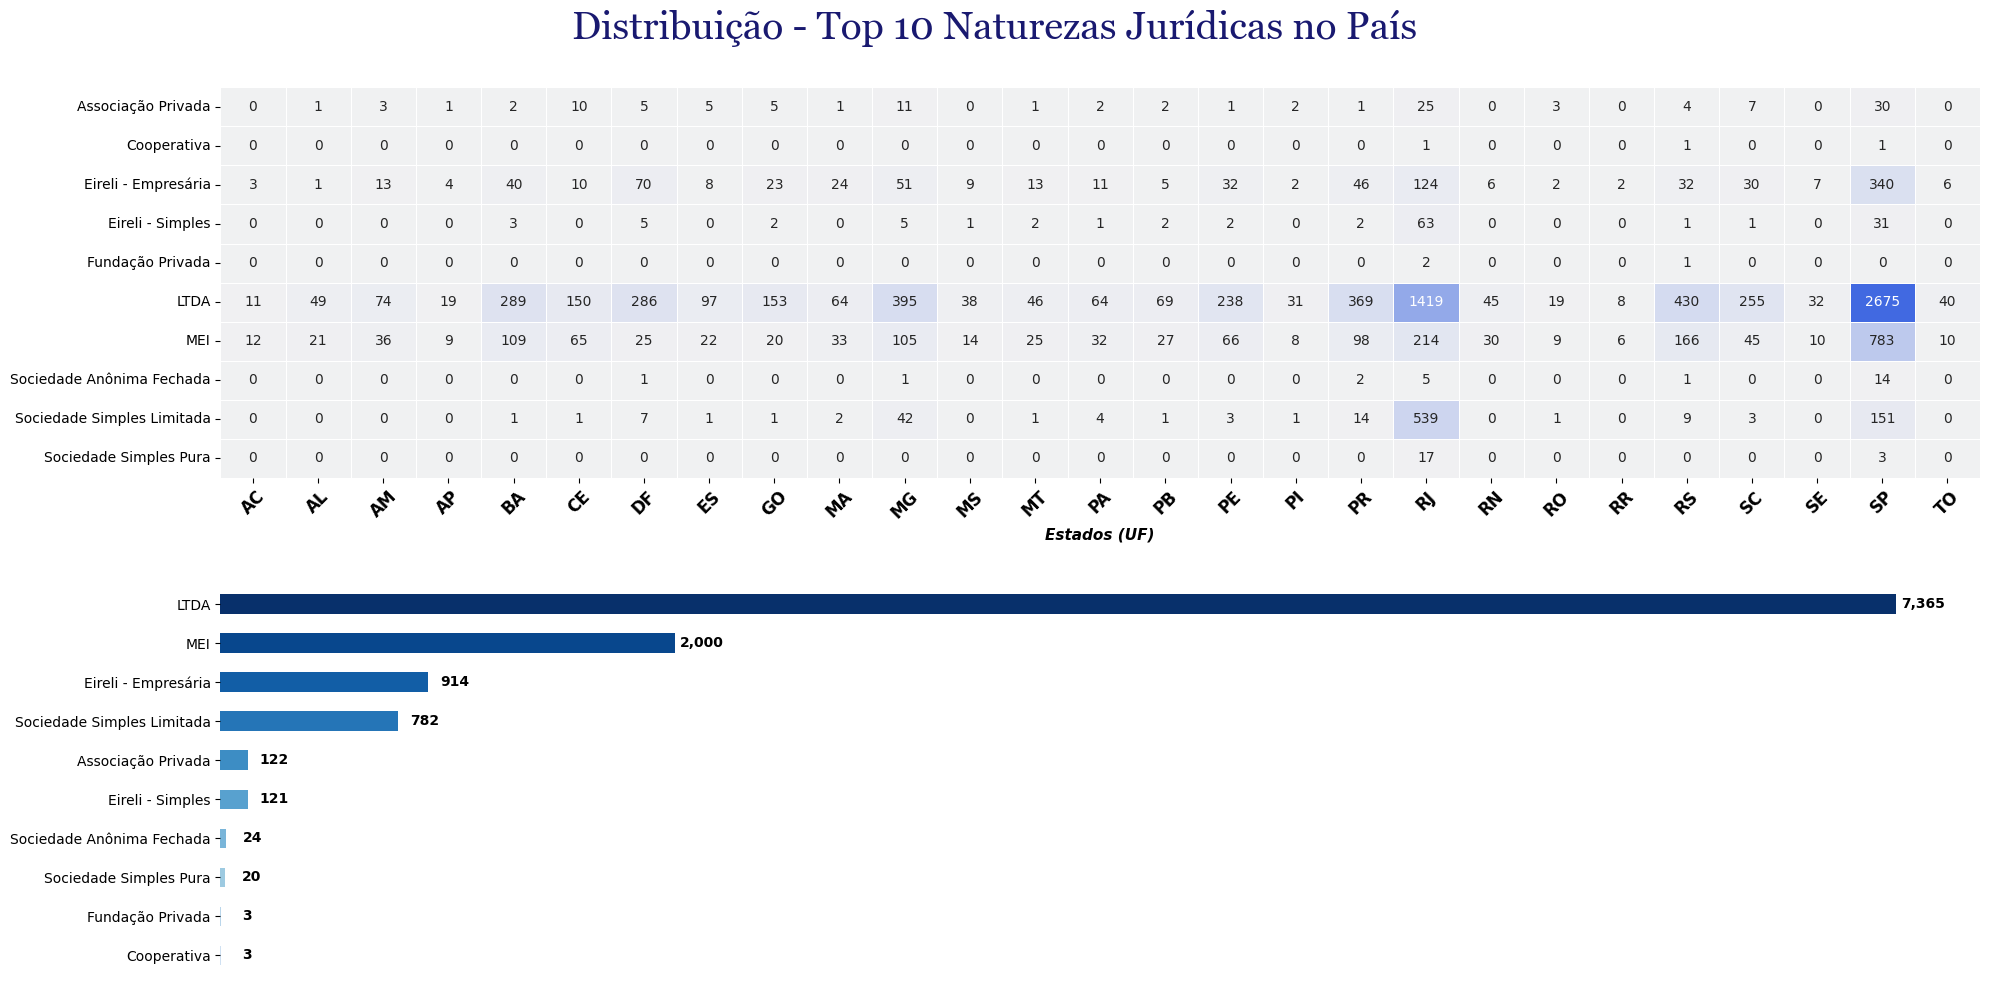

In [19]:
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 1)
axs = [plt.subplot(gs[i]) for i in range(2)]


natureza_juridica = pd.DataFrame(agnts_tabela_unificada)
natureza_juridica['NATUREZA_JURIDICA'] = natureza_juridica['NATUREZA_JURIDICA'].replace({
    'Sociedade Empresária Limitada': 'LTDA',
    'Empresário (Individual)': 'MEI',
    'Empresa Individual de Responsabilidade Limitada (de Natureza Empresária)': 'Eireli - Empresária',
    'Empresa Individual de Responsabilidade Limitada (de Natureza Simples)': 'Eireli - Simples'
})
ranking_natureza_juridica_top_10 = natureza_juridica['NATUREZA_JURIDICA'].value_counts().head(10)

cores = plt.cm.Blues(np.linspace(0.2, 1, len(ranking_natureza_juridica_top_10)))
ranking_natureza_juridica_top_10.sort_values(ascending=True).plot(kind='barh', color=cores, ax=axs[1])

for n in axs[1].patches:
    axs[1].annotate(format(n.get_width(), ',.0f'),
                    (n.get_width(), n.get_y() + n.get_height() / 2.),
                    ha='center', va='center',
                    xytext=(19, 0),
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')

axs[1].set_title('   ', fontsize=17, fontweight='medium')
axs[1].set_ylabel(None)
axs[1].set_xlabel(None)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontweight='medium')
axs[1].set_xticks([])
# axs[0].box(False)
# axs[0].set_yticks(fontweight='bold')
# axs[0].tight_layout()


pivot_table = pd.crosstab(natureza_juridica['NATUREZA_JURIDICA'], natureza_juridica['UF'])
cor = sns.color_palette("light:royalblue", as_cmap=True)
axs[0] = sns.heatmap(pivot_table, annot=True, fmt='d', linewidths=0.5, cmap=cor, ax=axs[0], cbar=False)
axs[0].set_xlabel('Estados (UF)', fontweight='bold', fontsize=11, fontstyle='oblique')
axs[0].set_ylabel(None)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontweight='medium', rotation=0)
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontweight='bold', fontsize=12, rotation=45)
axs[0].set_title("   ", fontsize=20)

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
plt.suptitle('Distribuição - Top 10 Naturezas Jurídicas no País', fontdict=fontprops, fontsize=28)
plt.subplots_adjust(top=1.87)
plt.subplots_adjust(hspace=1.5)
# plt.suptitle('Quantidade de Agentes por natureza jurídica', fontsize=14)
plt.box([])
plt.tight_layout()
plt.show()


---

3.0 Séries Temporais

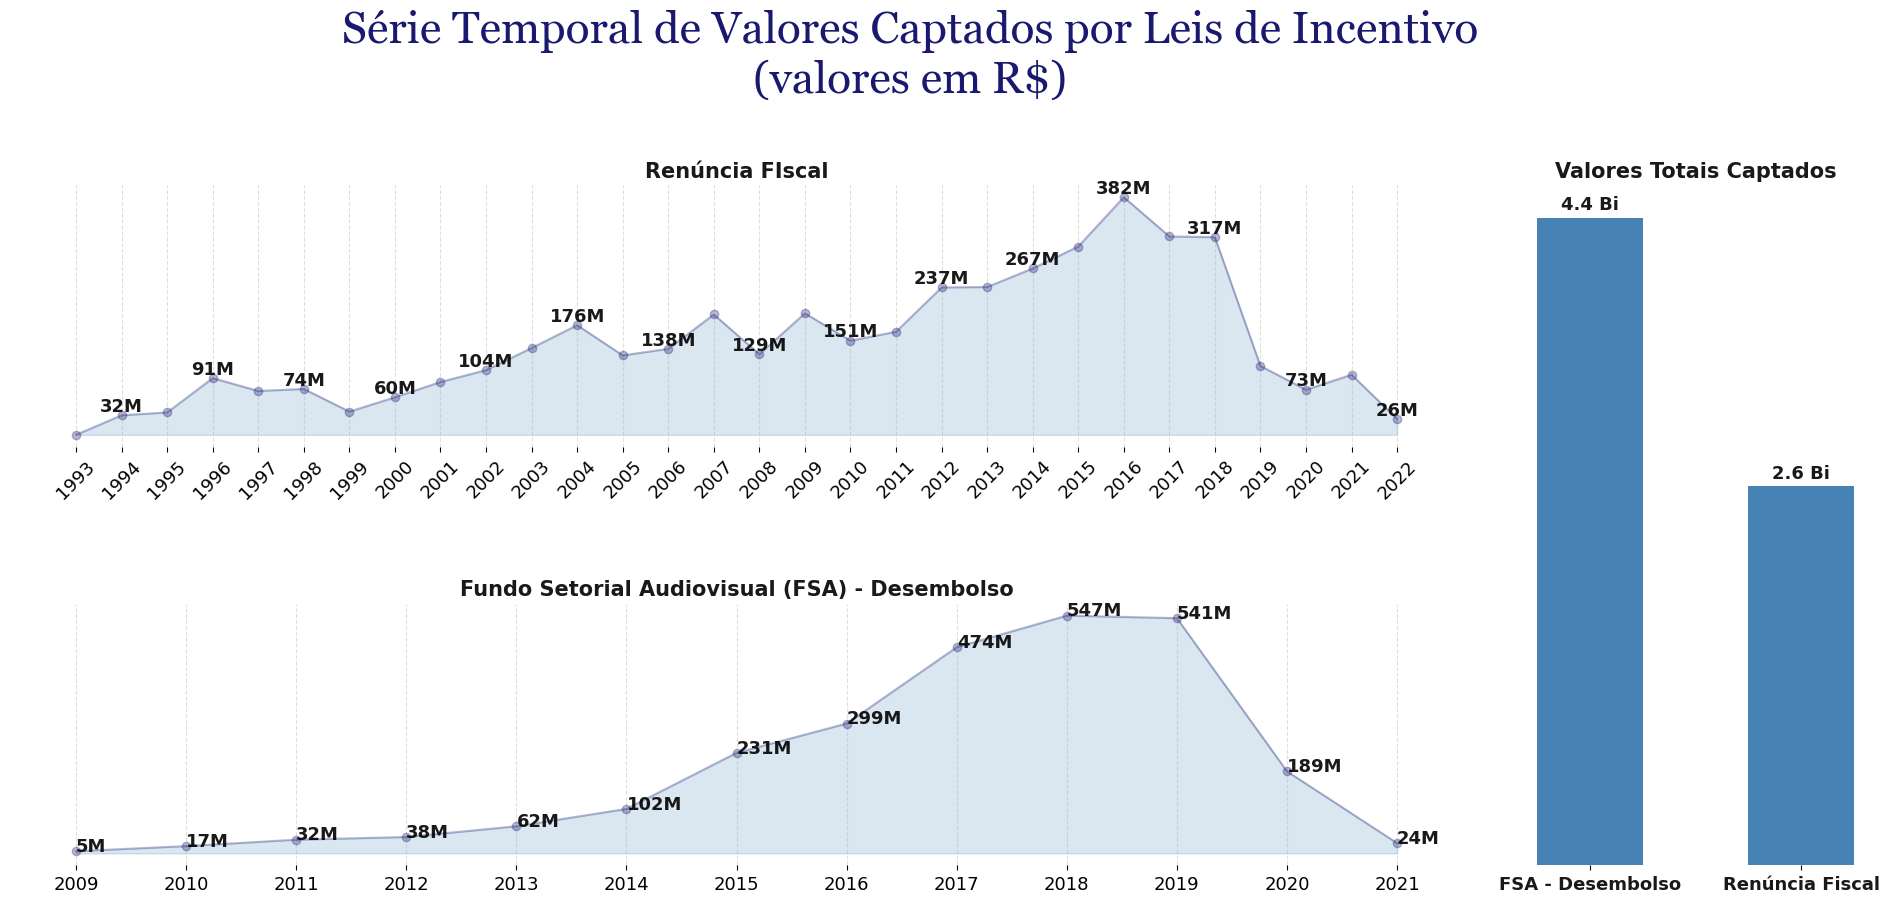

In [102]:
df_serie_temp_renun_fiscal = proj_renuncia_fiscal[['DT_APROVACAO_CAPTACAO', 'TOTAL_CAPTADO']]
df_serie_temp_renun_fiscal['TOTAL_CAPTADO'] = df_serie_temp_renun_fiscal['TOTAL_CAPTADO'].str.replace(',', '.').astype(float)
df_serie_temp_renun_fiscal['DT_APROVACAO_CAPTACAO'] = df_serie_temp_renun_fiscal['DT_APROVACAO_CAPTACAO'].dt.year
df_serie_temp_renun_fiscal = df_serie_temp_renun_fiscal.set_index('DT_APROVACAO_CAPTACAO')['TOTAL_CAPTADO']
df_serie_temp_renun_fiscal = df_serie_temp_renun_fiscal.groupby(df_serie_temp_renun_fiscal.index).sum().reset_index()
df_serie_temp_renun_fiscal_ano = df_serie_temp_renun_fiscal.set_index('DT_APROVACAO_CAPTACAO')['TOTAL_CAPTADO']

df_serie_temp_fsa_desembolso = proj_fsa_desembolso[['DT_PRIMEIRO_DESEMBOLSO', 'VL_TOTAL_LIBERADO']]
df_serie_temp_fsa_desembolso['VL_TOTAL_LIBERADO'] = df_serie_temp_fsa_desembolso['VL_TOTAL_LIBERADO'].str.replace(',', '.').astype(float)
df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = pd.to_datetime(df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'], errors='coerce')
df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.dropna(subset=['DT_PRIMEIRO_DESEMBOLSO'])
df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'].dt.year.astype(int)
df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.set_index('DT_PRIMEIRO_DESEMBOLSO')['VL_TOTAL_LIBERADO']
df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.groupby(df_serie_temp_fsa_desembolso.index).sum().reset_index()
df_serie_temp_fsa_desembolso_ano = df_serie_temp_fsa_desembolso.set_index('DT_PRIMEIRO_DESEMBOLSO')['VL_TOTAL_LIBERADO']

total_fsa_desembolso = df_serie_temp_fsa_desembolso_ano.sum()
total_renun_fiscal = df_serie_temp_renun_fiscal_ano.sum()

def grafico_fsa_renuncia_fiscal():

    #
    fig = plt.figure(figsize=(24,8))
    axs = [None for _ in range(3)]
    gs = gridspec.GridSpec(2, 3, width_ratios=[3, 1, 1])
    axs[0] = fig.add_subplot(gs[0, :-1])
    axs[1] = fig.add_subplot(gs[1, :-1])
    axs[2] = fig.add_subplot(gs[0:, -1])



    def valor_index(df, numero):
        count = 0
        for index, valor in df.items():
            milhoes = valor / 1e6
            
            if numero == 0:
                count += 1 
                if count % 2 == 0:
                    axs[0].text(index, valor, f"{milhoes:.0f}M", ha='center', va='bottom', fontweight='bold', fontsize=13, color='k', alpha=0.9)
                else:
                    continue
            else:
                axs[1].text(index, valor, f"{milhoes:.0f}M", fontweight='bold', fontsize=13, color='k', alpha=0.9)

    valor_index(df_serie_temp_fsa_desembolso_ano, 1)
    valor_index(df_serie_temp_renun_fiscal_ano, 0)

    axs[0].plot(df_serie_temp_renun_fiscal_ano.index, df_serie_temp_renun_fiscal_ano.values, color='midnightblue', marker='o', alpha=0.3, label='Serie Temp Renun Fiscal Ano')
    axs[0].set_xticks(df_serie_temp_renun_fiscal_ano.index)
    axs[0].set_xticklabels(df_serie_temp_renun_fiscal_ano.index, rotation=45, fontweight='light', alpha=1)
    axs[0].fill_between(df_serie_temp_renun_fiscal_ano.index, df_serie_temp_renun_fiscal_ano.values, color="steelblue", alpha=0.2)
    axs[0].tick_params(axis='x', which='minor', width=5)
    axs[0].set_yticks([])
    axs[0].grid(linestyle='dashed', alpha=0.4)
    axs[0].set_title('Renúncia FIscal', fontsize=15, fontweight='bold', alpha=0.9 )

    axs[1].plot(df_serie_temp_fsa_desembolso_ano.index, df_serie_temp_fsa_desembolso_ano.values, color='midnightblue', marker='o', alpha=0.3, label='Serie Temp Fsa Desembolso Ano')      
    axs[1].set_xticks(df_serie_temp_fsa_desembolso_ano.index)
    axs[1].set_xticklabels(df_serie_temp_fsa_desembolso_ano.index, rotation=0, fontweight='light', alpha=1)
    axs[1].fill_between(df_serie_temp_fsa_desembolso_ano.index, df_serie_temp_fsa_desembolso_ano.values, color="steelblue", alpha=0.2)
    axs[1].tick_params(axis='x', which='minor', width=5)
    axs[1].set_yticks([])
    axs[1].grid(linestyle='dashed', alpha=0.4)
    axs[1].set_title('Fundo Setorial Audiovisual (FSA) - Desembolso', fontsize=15, fontweight='bold', alpha=0.9 )


    # Plotting for axs[2]

    axs[2].bar(['FSA - Desembolso', 'Renúncia Fiscal'], [total_renun_fiscal, total_fsa_desembolso], width=0.5, color='steelblue')
    for rect in axs[2].patches:
        height = rect.get_height()
        value_in_billions = height / 1e9  # Convert value to billions
        rounded_value = round(value_in_billions, 1)  # Round to one decimal place
        annot_text = f'{rounded_value:,.1f} Bi'
        axs[2].annotate(annot_text, xy=(rect.get_x() + rect.get_width() / 2  , height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold', fontsize=13, alpha=0.9)
    axs[2].set_xticklabels(['FSA - Desembolso', 'Renúncia Fiscal'], rotation=0, fontweight='bold', alpha=0.9)
    axs[2].set_title('Valores Totais Captados', fontsize=15, fontweight='bold', alpha=0.9)
    # Set tick parameters and labels
    for ax_single in axs:
        ax_single.tick_params(axis='both', which='major', labelsize=13) 
        ax_single.set_ylabel(None)  
        ax_single.set_yticks([])

    # Remove spines
    for ax_single in axs:
        ax_single.spines['top'].set_visible(False)
        ax_single.spines['right'].set_visible(False)
        ax_single.spines['bottom'].set_visible(False)
        ax_single.spines['left'].set_visible(False)

    # Adjust the spacing around subplots
    plt.subplots_adjust(top=0.95, bottom=0.1, wspace=0.1, hspace=0.6)

    # Add title
    fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
    plt.suptitle('Série Temporal de Valores Captados por Leis de Incentivo\n(valores em R$)', fontdict=fontprops, fontsize=32, y=1.17)
    # Show the plot
    plt.show()

grafico_fsa_renuncia_fiscal()

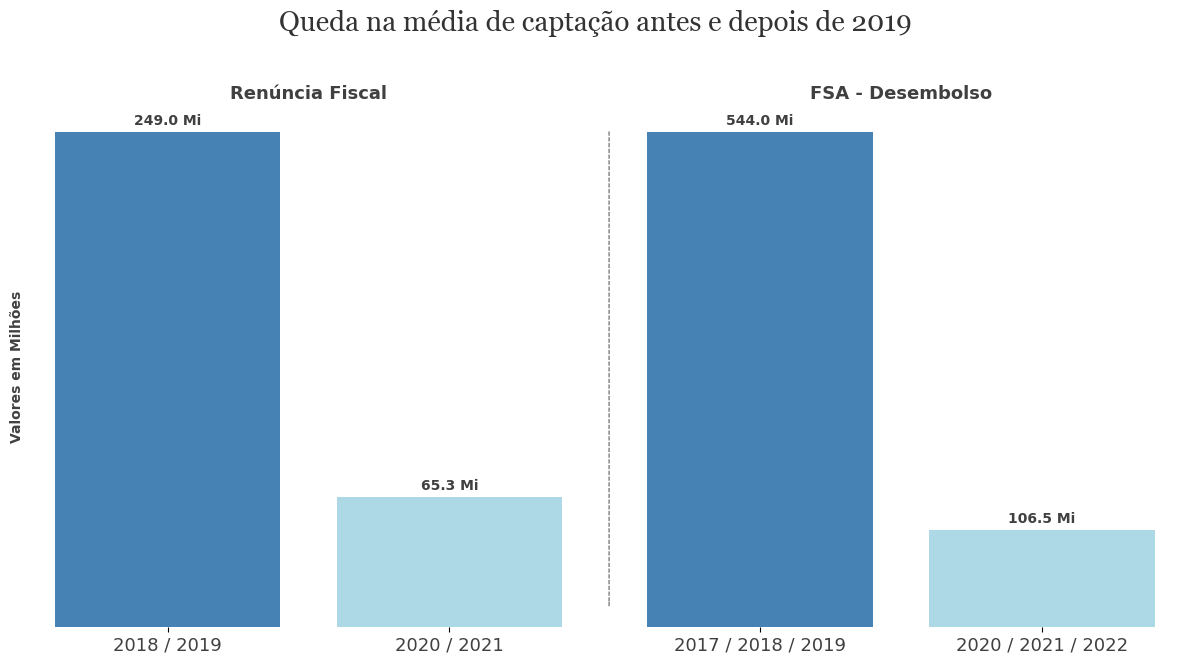

In [103]:
# Dados
total_renun_fiscal_balanco = {
    'pre_2019': 249,
    'pos_2019': 65.3
}

total_fsa_desembolso_balanco = {
    'pre_2019': 544,
    'pos_2019': 106.5
}

# Preparando os dados para os gráficos
categories_1 = ['2018 / 2019', '2020 / 2021']
categories_2 = ['2017 / 2018 / 2019', '2020 / 2021 / 2022']
renuncia_fiscal = [total_renun_fiscal_balanco['pre_2019'], total_renun_fiscal_balanco['pos_2019']]
fsa_desembolso = [total_fsa_desembolso_balanco['pre_2019'], total_fsa_desembolso_balanco['pos_2019']]

x_1 = np.arange(len(categories_1))  # Posições das categorias
x_2 = np.arange(len(categories_2))  # Posições das categorias
width = 0.8  # Largura das barras

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Cores para as barras
colors_ = ['darkgreen', 'darkred']
colors = ['steelblue', 'lightblue']

# Gráfico de Renúncia Fiscal
bars1 = axs[0].bar(x_1, renuncia_fiscal, width, color=colors)

# Adicionando os valores no topo das barras
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        annot_text = f'{height:,.1f} Mi'
        ax.annotate(annot_text,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 pontos de deslocamento vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold', fontsize=10, alpha=0.75)

add_value_labels(axs[0], bars1)

# Configurações do gráfico de Renúncia Fiscal
# axs[0].set_xlabel('Período', fontweight='bold', alpha=0.75)
axs[0].set_ylabel('Valores em Milhões', fontweight='bold', alpha=0.75)
axs[0].set_title('Renúncia Fiscal', fontsize=13, fontweight='bold', alpha=0.75)
axs[0].set_xticks(x)
axs[0].set_xticklabels(categories_1, rotation=0, fontweight='normal', alpha=0.75)

# Gráfico de FSA - Desembolso
bars2 = axs[1].bar(x, fsa_desembolso, width, color=colors)

# Adicionando os valores no topo das barras
add_value_labels(axs[1], bars2)

# Configurações do gráfico de FSA - Desembolso
# axs[1].set_xlabel('Período', fontweight='bold', alpha=0.75)
axs[1].set_ylabel('-----------------------------------------------------------------------------------', fontweight='bold', alpha=0.4)
axs[1].set_title('FSA - Desembolso', fontsize=13, fontweight='bold', alpha=0.75)
axs[1].set_xticks(x)
axs[1].set_xticklabels(categories_2, rotation=0, fontweight='normal', alpha=0.75)

# Ajustes nas grades e eixos
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])

# Ajustando o layout
plt.tight_layout()

# Adicionando título geral
fontprops = {'color': 'black', 'weight': 'bold', 'style': 'normal', 'family': 'Georgia'}
plt.suptitle('Queda na média de captação antes e depois de 2019', fontdict=fontprops, fontsize=20, alpha=0.8, y=1.10)

# Mostrando o gráfico
plt.show()


In [41]:
df_serie_temp_fsa_desembolso_ano

DT_PRIMEIRO_DESEMBOLSO
2009    5.000000e+06
2010    1.681196e+07
2011    3.152293e+07
2012    3.773083e+07
2013    6.247644e+07
2014    1.024177e+08
2015    2.313928e+08
2016    2.987470e+08
2017    4.744015e+08
2018    5.469145e+08
2019    5.411005e+08
2020    1.887356e+08
2021    2.358152e+07
Name: VL_TOTAL_LIBERADO, dtype: float64

---

## 3.0 Modelagem Estatística

#### Adequando dataframes

In [22]:
def stats_df(df):

    numerical = df.select_dtypes(exclude=('datetime64[ns]', 'object', 'bool'))

    media = pd.DataFrame(numerical.mean()).T
    mediana = pd.DataFrame(numerical.median()).T

    desvio_padrao = pd.DataFrame(numerical.apply(np.std)).T
    minimo = pd.DataFrame(numerical.min()).T
    maximo = pd.DataFrame(numerical.max()).T
    range = pd.DataFrame(numerical.apply(lambda x: x.max() - x.min())).T
    skew = pd.DataFrame(numerical.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(numerical.apply(lambda x: x.kurtosis())).T

    nome_stats_df = 'stats_' + str(df)
    nome_stats_df = pd.concat([media, mediana, desvio_padrao, minimo, maximo, range, skew, kurtosis]).T.reset_index()

    if df is fsa_desembolso:
        nome_df = 'FSA - Desembolso'
    else:
        nome_df = 'Renúncia Fiscal'
    nome_stats_df.columns = [nome_df, 'Média', 'Mediana', 'Desvio Padrão', 'Mínimo', 'Máximo', 'Range', 'Skew', 'Kurtosis']
    return nome_stats_df


3.1 Dados Estatísticos - Renúncia Fiscal

In [23]:
stats_df(renuncia_fiscal)

,Renúncia Fiscal,Média,Mediana,Desvio Padrão,Mínimo,Máximo,Range,Skew,Kurtosis
0,REGISTRO_ANCINE,6.732374e+03,1288.0,9.352180e+03,1.0,4.919500e+04,4.919400e+04,1.551831,1.760444
1,CLASSIFICACAO_NIVEL_PRODUTORA,3.548103e+00,4.0,1.443481e+00,1.0,5.000000e+00,4.000000e+00,-0.572314,-1.085240
2,LEI_8313,7.759371e+04,0.0,2.706875e+05,0.0,3.313201e+06,3.313201e+06,5.191387,34.062702
3,ART1,2.517539e+05,0.0,5.737106e+05,0.0,4.000000e+06,4.000000e+06,3.010705,9.599093
4,ART1A,2.865164e+05,0.0,5.680820e+05,0.0,4.000000e+06,4.000000e+06,2.946871,10.592457
5,ART3,2.369118e+05,0.0,6.743896e+05,0.0,4.320000e+06,4.320000e+06,3.142201,9.061842
6,ART3A,3.895909e+05,0.0,8.392261e+05,0.0,3.000000e+06,3.000000e+06,2.242597,3.692846
7,ART39,2.496303e+05,0.0,1.033442e+06,0.0,1.463493e+07,1.463493e+07,7.056844,64.568354
8,FUNCINES,2.447739e+04,0.0,2.166931e+05,0.0,6.000000e+06,6.000000e+06,15.377741,319.888224
9,TOTAL_CAPTADO,1.516474e+06,812000.0,1.670596e+06,0.0,1.463493e+07,1.463493e+07,2.050779,6.684717


3.2 Dados Estatísticos - Renúncia Fiscal

In [24]:
stats_df(fsa_desembolso)

,FSA - Desembolso,Média,Mediana,Desvio Padrão,Mínimo,Máximo,Range,Skew,Kurtosis
0,REGISTRO_ANCINE,12405.355204,13029.00,10858.425570,3.00,46335.0,46332.00,0.472236,-0.930614
1,CLASSIFICACAO_NIVEL_PRODUTORA,2.733970,3.00,1.536581,1.00,5.0,4.00,0.182527,-1.503488
2,ANO_CHAMADA_PUBLICA,2014.917984,2015.00,2.234697,2008.00,2020.0,12.00,-0.105695,0.166489
3,VL_CONTRATO_DOU,673425.733278,434109.65,718085.274060,5853.11,6107400.0,6101546.89,2.213104,6.634189
4,VL_TOTAL_LIBERADO,640483.844837,400000.00,713290.155240,0.00,6107400.0,6107400.00,2.249797,6.901420


3.3 Atributos Numéricos

In [25]:
fsa_desembolso_numerical = fsa_desembolso.select_dtypes(exclude=('datetime64[ns]', 'object', 'bool'))
renuncia_fiscal_numerical = renuncia_fiscal.select_dtypes(exclude=('datetime64[ns]', 'object', 'bool'))


def plot_hist_renuncia_fiscal():

    fig = plt.figure(figsize=(18,10))
    axs = [None] * 4
    gs = gridspec.GridSpec(2, 2)
    axs[0] = fig.add_subplot(gs[0,0])
    axs[1] = fig.add_subplot(gs[0,1])
    axs[2] = fig.add_subplot(gs[1,0])
    axs[3] = fig.add_subplot(gs[1,1])

    n_bins = 40

    labels = {
        'CLASSIFICACAO_NIVEL_PRODUTORA' : 'Nível de Classificação',
        'ANO_CHAMADA_PUBLICA' : 'Ano da Chamada Pública',
        'VL_CONTRATO_DOU' : 'Valor do Contrato',
        'VL_TOTAL_LIBERADO' : 'Valor Liberado',
    }

    #Plot Hist - Renúncia Fiscal
    for i, column in enumerate(['CLASSIFICACAO_NIVEL_PRODUTORA', 'ANO_CHAMADA_PUBLICA', 'VL_CONTRATO_DOU', 'VL_TOTAL_LIBERADO']):
        sns.histplot(fsa_desembolso_numerical[column], bins=n_bins, kde=True, ax=axs[i], 
                     stat='percent', line_kws={'color': 'red'})
        axs[i].set_title(labels[column])
        axs[i].set_xlabel(None)


    plt.tight_layout()
    plt.show()

def plot_hist_fsa_desembolso():
    
    fig = plt.figure(figsize=(16,12))
    axs = [None] * 8
    gs = gridspec.GridSpec(4, 3)
    axs[0] = fig.add_subplot(gs[0,0])
    axs[1] = fig.add_subplot(gs[0,1])
    axs[2] = fig.add_subplot(gs[1,0])
    axs[3] = fig.add_subplot(gs[1,1])
    axs[4] = fig.add_subplot(gs[2,0])
    axs[5] = fig.add_subplot(gs[2,1])
    axs[6] = fig.add_subplot(gs[3,0])
    axs[7] = fig.add_subplot(gs[3,1])

    n_bins = 40

    labels = {
        'LEI_8313' : 'Lei 8313 (Lei Rouanet)',
        'ART1' : 'Artigo 1°',
        'ART1A' : 'Artigo 1°.A',
        'ART3' : 'Artigo 3°',
        'ART3A' : 'Artigo 3°.A',
        'ART39' : 'Artigo 39°',
        'FUNCINES' : 'FUNCINES - Fundo Municipal de Cinema',
        'TOTAL_CAPTADO' : 'Total Captado',
    }
    #Plot Hist - FSA - Desembolso
    for i, column in enumerate(['LEI_8313', 'ART1',
        'ART1A', 'ART3', 'ART3A', 'ART39', 'FUNCINES', 'TOTAL_CAPTADO']):
        sns.histplot(renuncia_fiscal_numerical[column], bins=n_bins, kde=True, ax=axs[i], stat='percent')
        axs[i].set_title(labels[column])
        axs[i].set_xlabel(None)
    # plt.box([])
    plt.tight_layout()
    plt.show()

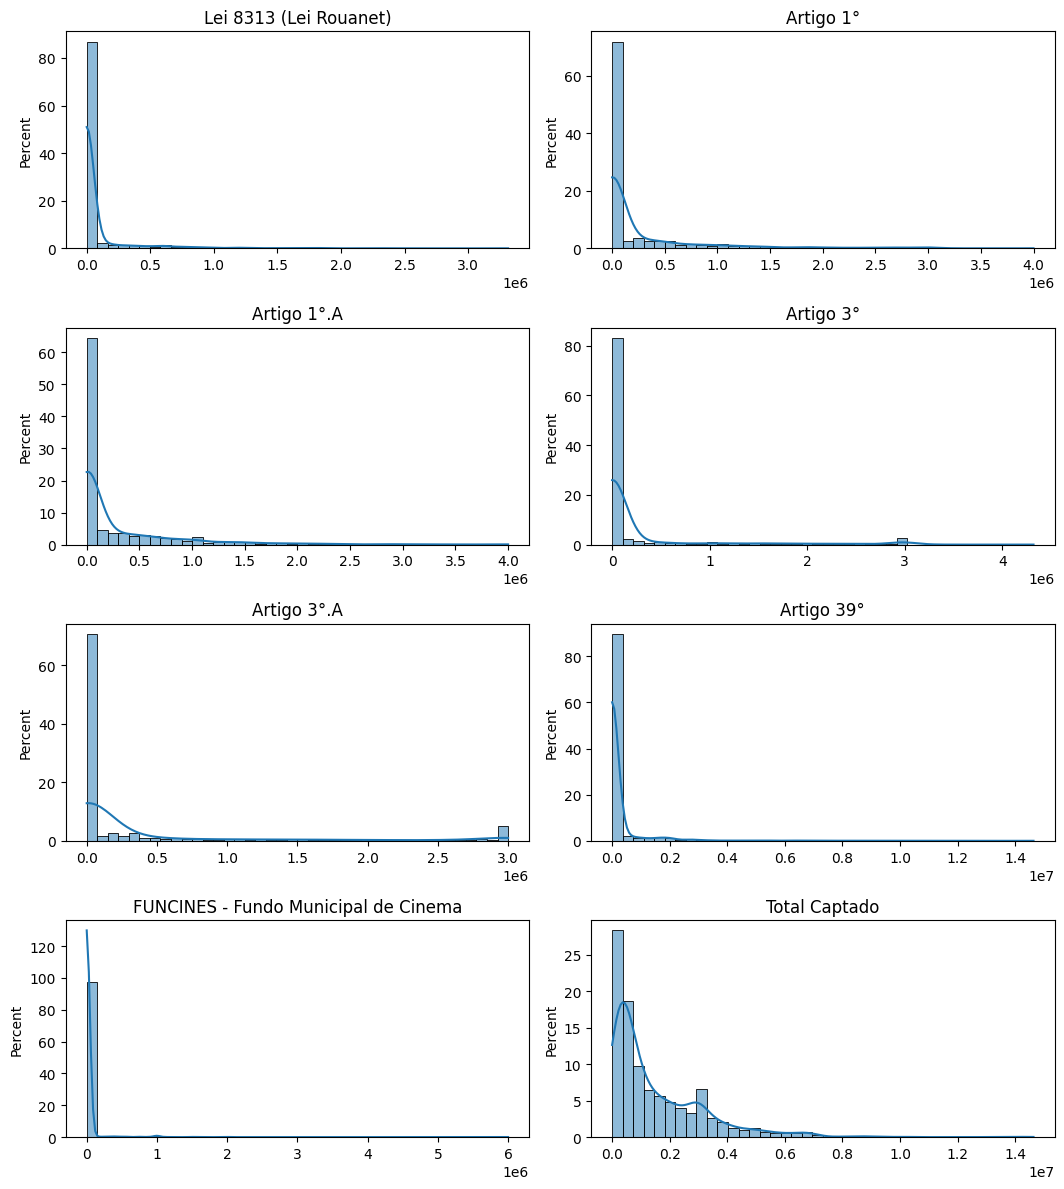

In [26]:
plot_hist_fsa_desembolso()

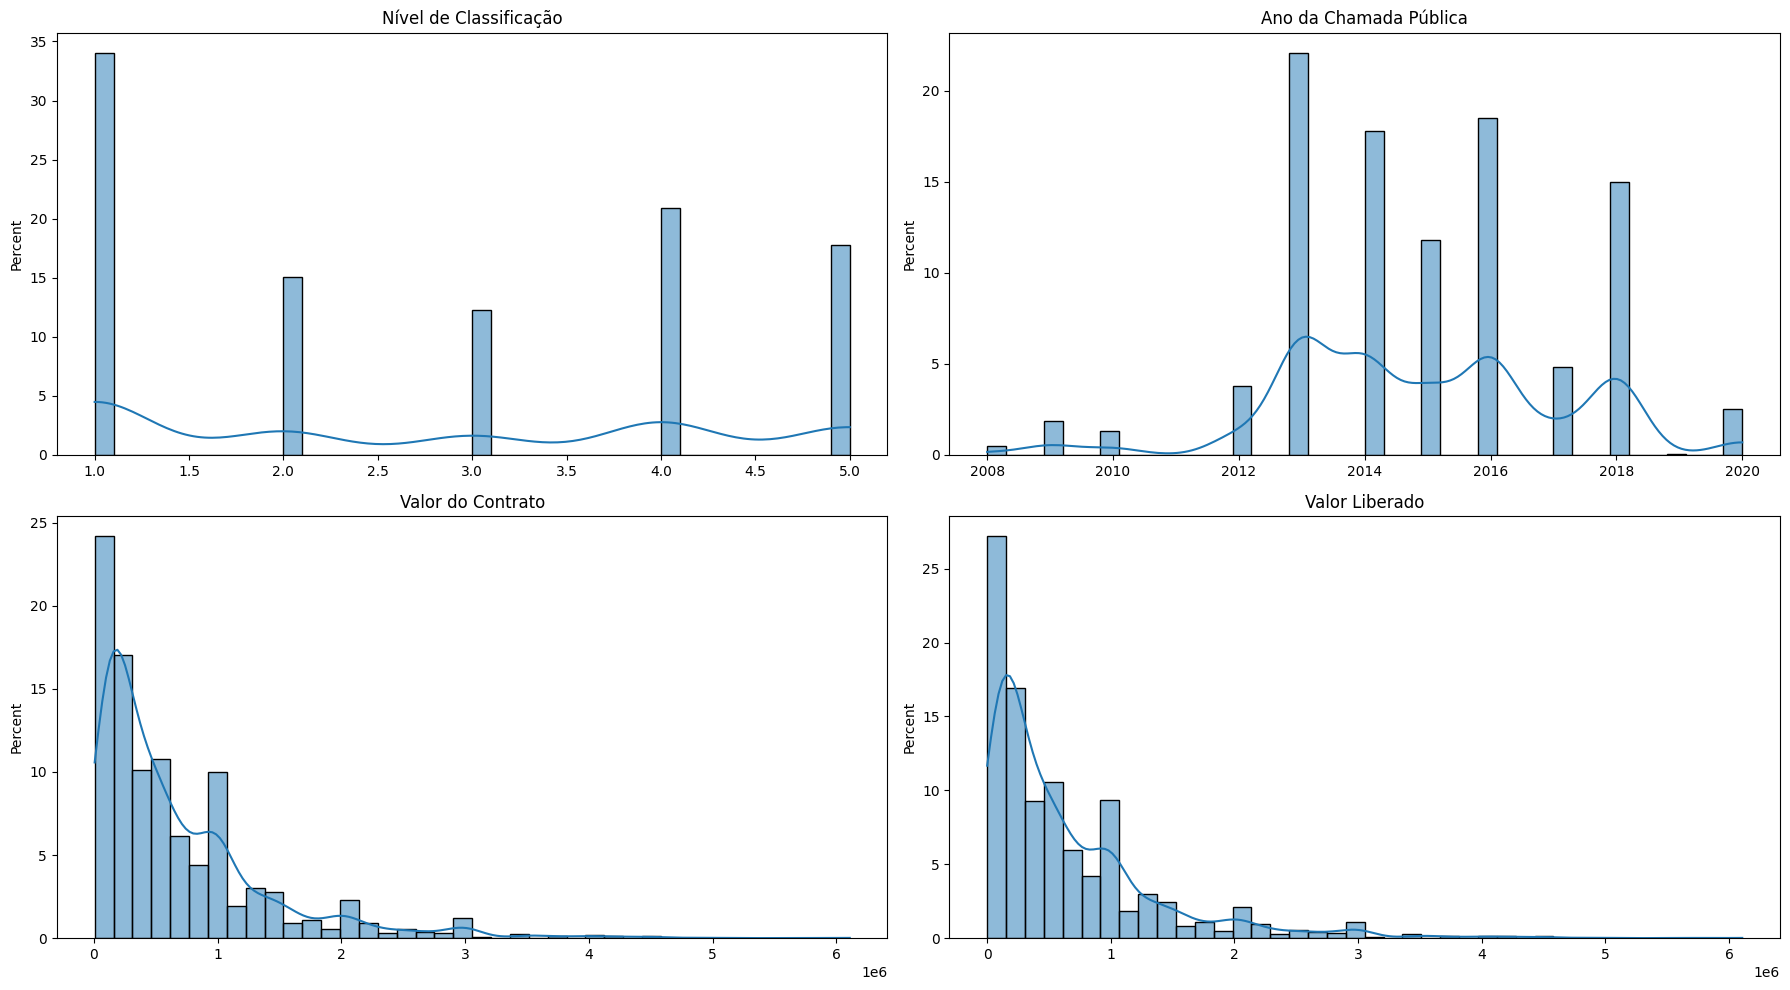

In [27]:
plot_hist_renuncia_fiscal()

3.4 Atributos Categóricos

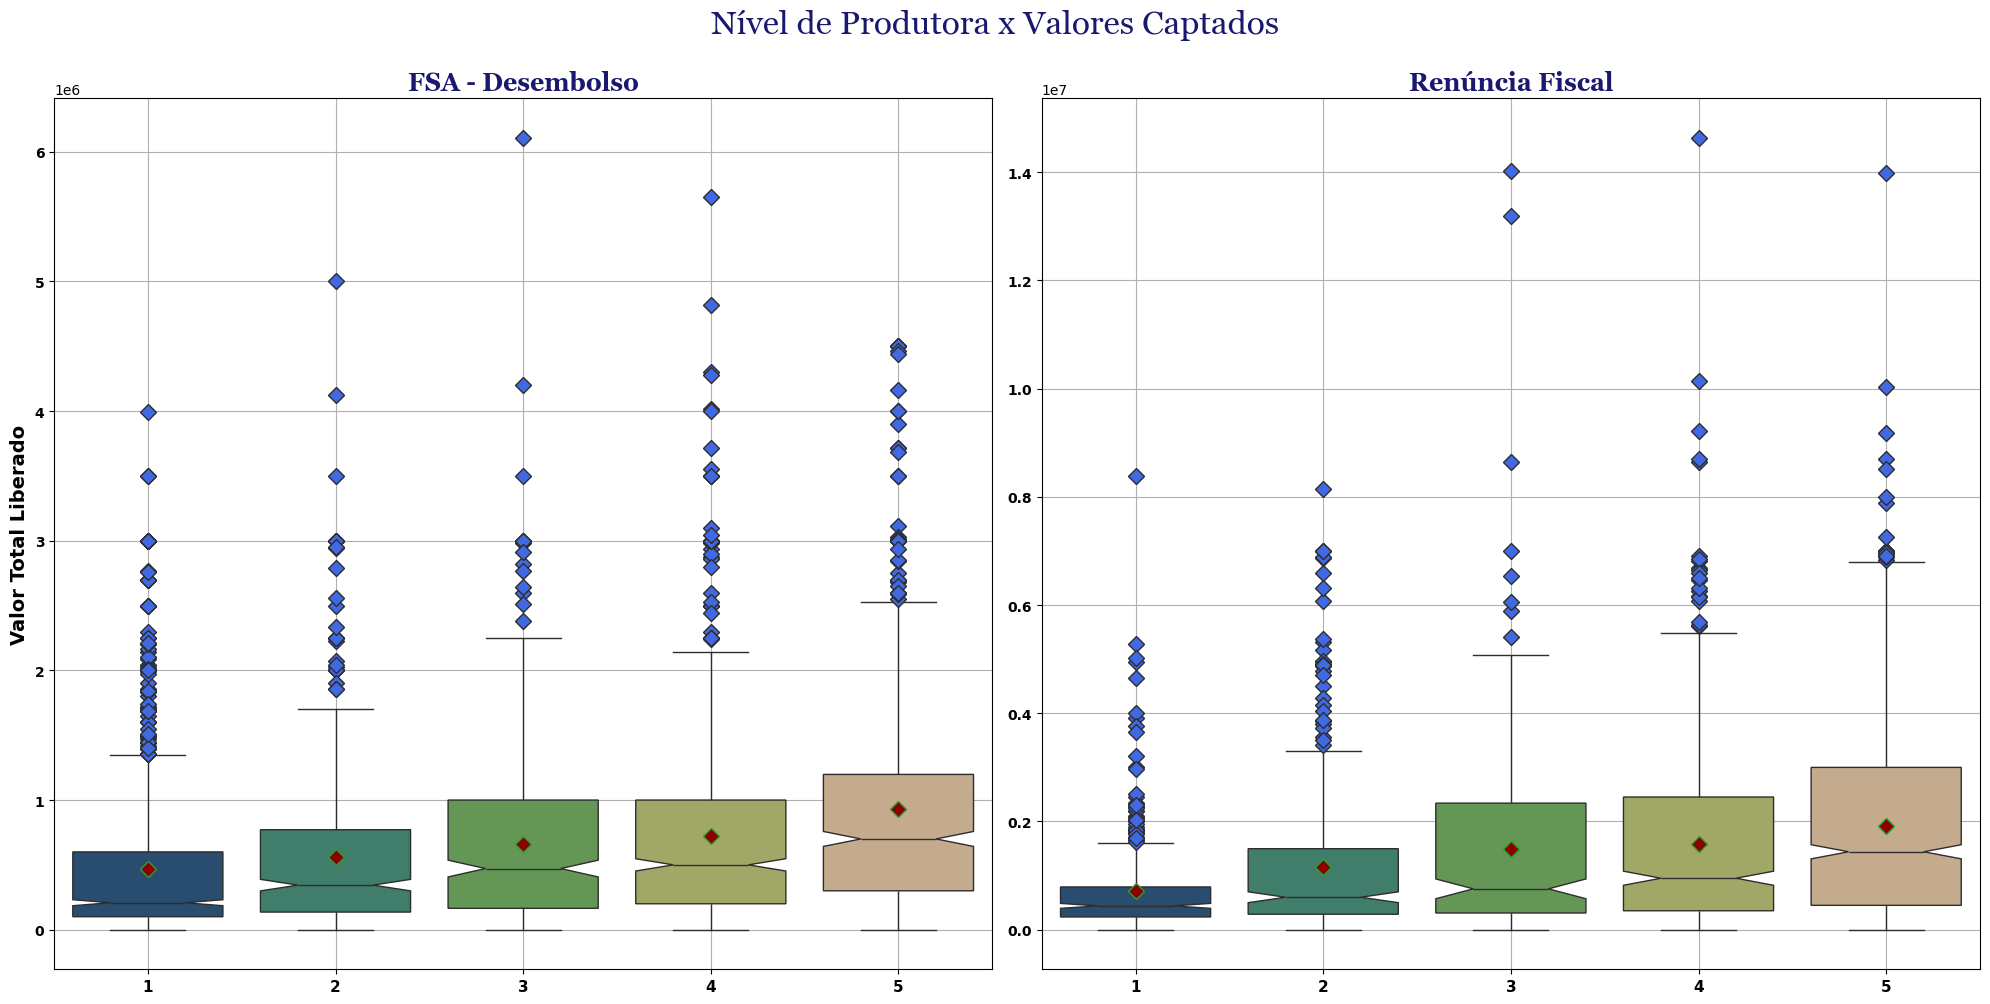

In [28]:

data_fsa = fsa_desembolso
data_renuncia = renuncia_fiscal

fig = plt.figure(figsize=(20,10))
axs = [None] * 2
gs = gridspec.GridSpec(1, 2)
axs[0] = fig.add_subplot(gs[0,0])
axs[1] = fig.add_subplot(gs[0,1])

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
flierprops = dict(marker='D', markerfacecolor='royalblue', markersize=8, linestyle='none')
meanprops = dict(marker='D', markerfacecolor='darkred', markersize=8)

axs[0] = plt.subplot(1, 2, 1)
sns.boxplot(x='CLASSIFICACAO_NIVEL_PRODUTORA', y='VL_TOTAL_LIBERADO', data=data_fsa, 
            notch=True, showmeans=True, meanprops=meanprops, 
            palette='gist_earth', flierprops=flierprops)
axs[0] = plt.xticks(fontweight='bold', fontsize=11)
axs[0] = plt.ylabel('Valor Total Liberado', fontweight='bold', fontsize=14)
axs[0] = plt.title('FSA - Desembolso', fontdict=fontprops, fontsize=18)
# axs[0] = plt.box(None)
axs[0] = plt.grid(None)
axs[0] = plt.yticks(fontsize=10, fontweight='bold')
axs[0] = plt.xlabel(None)

axs[1] =  plt.subplot(1, 2, 2)
sns.boxplot(x='CLASSIFICACAO_NIVEL_PRODUTORA', y='TOTAL_CAPTADO', data=data_renuncia, 
            notch=True, showmeans=True, meanprops=meanprops,
              palette='gist_earth', flierprops=flierprops)
axs[1] = plt.xticks(fontweight='bold', fontsize=11)
axs[1] = plt.ylabel(None)
axs[1] = plt.title('Renúncia Fiscal', fontdict=fontprops, fontsize=18)
# axs[1] = plt.box(None)
axs[1] = plt.grid(None)
axs[1] = plt.yticks(fontsize=10, fontweight='bold')
axs[1] = plt.xlabel(None)

plt.suptitle('Nível de Produtora x Valores Captados', fontdict=fontprops, fontsize=24, y=1.0)
plt.tight_layout()
plt.show()

---

## Feature Engineering

### Criação de Hipóteses

### FSA - Desembolso

* Projetos no Sudeste tem maior probabilidade de serem aprovados
* Projetos captados via natureza jurídica LTDA tem prazo de liberação menor que outras naturezas jurídicas
* Projetos captados via natureza jurídica MEI tem maior chance de serem reprovados 
* O número de projetos aprovados em um estado é diretamente proporcional a quantidade de projetos inscritos, independentemente de localização

### Renúncia Fiscal

* Projetos no Sudeste tem maior probabilidade de serem aprovados
* Projetos captados via natureza jurídica LTDA tem prazo de liberação menor que outras naturezas jurídicas
* Projetos captados via natureza jurídica MEI tem maior chance de serem reprovados 


---

In [29]:
fsa_desembolso_numerical

,REGISTRO_ANCINE,CLASSIFICACAO_NIVEL_PRODUTORA,ANO_CHAMADA_PUBLICA,VL_CONTRATO_DOU,VL_TOTAL_LIBERADO
0,3,2,2018,200000.00,200000.00
1,10,5,2008,1000000.00,1000000.00
2,10,5,2009,1206746.32,1206746.32
3,10,5,2012,350000.00,350000.00
4,15,4,2010,500000.00,500000.00
...,...,...,...,...,...
3348,42175,1,2018,120000.00,120000.00
3349,43382,1,2018,100000.00,100000.00
3350,44412,1,2020,150780.00,150780.00
3351,45889,1,2020,77349.00,77349.00


In [30]:
#Linear Regression for FSA dataset
def linear_regression_fsa(y):
    
    X = fsa_desembolso_numerical[['ANO_CHAMADA_PUBLICA']]

    lin_reg = lm.LinearRegression()
    lin_reg.fit(X, y)
    ypred = lin_reg.predict(X)
    print('Dependent Variable:', y.name)
    print('Coefficient', lin_reg.coef_)
    print('Intercept', lin_reg.intercept_)
    print('MSQERR', msqerr(y, ypred))
    print('R2', lin_reg.score(X,y))

    plt.figure()
    plt.scatter(X,y)
    plt.plot(X, ypred, color='red')
    plt.xlabel('Ano da Chamada Pública')
    plt.ylabel(y.name)

In [31]:
renuncia_fiscal_numerical

,REGISTRO_ANCINE,CLASSIFICACAO_NIVEL_PRODUTORA,LEI_8313,ART1,ART1A,ART3,ART3A,ART39,FUNCINES,TOTAL_CAPTADO
0,1,1,0.0,274171.0,0.0,0.0,0.0,0.0,0.0,274171.0
1,1,1,120000.0,212925.0,0.0,0.0,0.0,0.0,0.0,332925.0
2,1,1,0.0,120000.0,0.0,0.0,0.0,0.0,0.0,120000.0
3,1,1,0.0,206366.0,0.0,0.0,0.0,0.0,0.0,206366.0
4,1,1,265000.0,0.0,0.0,0.0,0.0,0.0,0.0,265000.0
...,...,...,...,...,...,...,...,...,...,...
2604,46150,1,0.0,0.0,0.0,0.0,950000.0,0.0,0.0,950000.0
2605,48102,1,0.0,0.0,0.0,0.0,600000.0,0.0,0.0,600000.0
2606,48102,1,0.0,0.0,0.0,0.0,1026000.0,0.0,0.0,1026000.0
2607,49195,1,0.0,889239.0,64000.0,0.0,0.0,0.0,0.0,953239.0


In [32]:
sudeste = ['SP', 'RJ', 'MG', 'ES']
fsa_desembolso_sudeste = fsa_desembolso[fsa_desembolso['UF'].isin(sudeste)]
fsa_desembolso_sudeste['APROVADO'] = fsa_desembolso_sudeste['VL_TOTAL_LIBERADO'] > 0
fsa_desembolso_sudeste['APROVADO'].value_counts()

APROVADO
True     1939
False      61
Name: count, dtype: int64

In [33]:
sudeste = ['SP', 'RJ', 'MG', 'ES']
renuncia_fiscal_numerical_sudeste = renuncia_fiscal[renuncia_fiscal['UF'].isin(sudeste)]
renuncia_fiscal_numerical_sudeste

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_NIVEL_PRODUTORA,...,LEI_8313,ART1,ART1A,ART3,ART3A,ART39,FUNCINES,TOTAL_CAPTADO,DT_APROVACAO_CAPTACAO,DT_1_LIBERACAO
0,1,2002-12-18,M. ALTBERG CINEMA E VÍDEO LTDA,39.939.269/0001-73,1993-01-05,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,...,0.0,274171.0,0.0,0.0,0.0,0.0,0.0,274171.0,1995-10-11,1996-12-27
1,1,2002-12-18,M. ALTBERG CINEMA E VÍDEO LTDA,39.939.269/0001-73,1993-01-05,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,...,120000.0,212925.0,0.0,0.0,0.0,0.0,0.0,332925.0,1995-08-16,1999-07-22
2,1,2002-12-18,M. ALTBERG CINEMA E VÍDEO LTDA,39.939.269/0001-73,1993-01-05,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,...,0.0,120000.0,0.0,0.0,0.0,0.0,0.0,120000.0,1996-12-03,2001-01-18
3,1,2002-12-18,M. ALTBERG CINEMA E VÍDEO LTDA,39.939.269/0001-73,1993-01-05,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,...,0.0,206366.0,0.0,0.0,0.0,0.0,0.0,206366.0,1996-12-03,2000-09-14
4,1,2002-12-18,M. ALTBERG CINEMA E VÍDEO LTDA,39.939.269/0001-73,1993-01-05,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,...,265000.0,0.0,0.0,0.0,0.0,0.0,0.0,265000.0,2000-06-07,2001-03-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604,46150,2020-07-21,FLUXA FILMES LTDA,34.878.582/0001-25,2019-09-16,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,...,0.0,0.0,0.0,0.0,950000.0,0.0,0.0,950000.0,2021-10-15,2022-07-18
2605,48102,2021-04-06,VAMO QUE VAMO FILMES - EIRELI,32.785.981/0001-16,2019-02-15,RJ,RIO DE JANEIRO,Empresa Individual de Responsabilidade Limitad...,"Atividades de produção cinematográfica, de víd...",1,...,0.0,0.0,0.0,0.0,600000.0,0.0,0.0,600000.0,2021-07-12,2022-08-05
2606,48102,2021-04-06,VAMO QUE VAMO FILMES - EIRELI,32.785.981/0001-16,2019-02-15,RJ,RIO DE JANEIRO,Empresa Individual de Responsabilidade Limitad...,"Atividades de produção cinematográfica, de víd...",1,...,0.0,0.0,0.0,0.0,1026000.0,0.0,0.0,1026000.0,2022-06-24,2022-12-22
2607,49195,2021-08-05,BLAH SERVICOS DE COMUNICACAO EIRELI,39.737.740/0001-40,2020-11-10,RJ,RIO DE JANEIRO,Empresa Individual de Responsabilidade Limitad...,Atividades de exibição cinematográfica,1,...,0.0,889239.0,64000.0,0.0,0.0,0.0,0.0,953239.0,2021-11-26,2022-06-23


In [34]:
#Linear Regression for Renúncia fiscal dataset - Classificação de Nivel
def linear_regression_renuncia_fiscal(y):

    X = renuncia_fiscal_numerical[['CLASSIFICACAO_NIVEL_PRODUTORA']]

    lin_reg = lm.LinearRegression()
    lin_reg.fit(X,y)
    ypred = lin_reg.predict(X)

    ypred = lin_reg.predict(X)
    print('Dependent Variable:', y.name)
    print('Coefficient', lin_reg.coef_)
    print('Intercept', lin_reg.intercept_)
    print('MSQERR', msqerr(y, ypred))
    print('R2', lin_reg.score(X,y))

    plt.figure()
    plt.scatter(X,y)
    plt.plot(X, ypred, color='red')
    plt.xlabel('Classificação de Nivel de produtora')
    plt.ylabel(y.name)

Dependent Variable: LEI_8313
Coefficient [-210.15035492]
Intercept 78339.34420287167
MSQERR 73271642436.16594
R2 1.255874313876859e-06


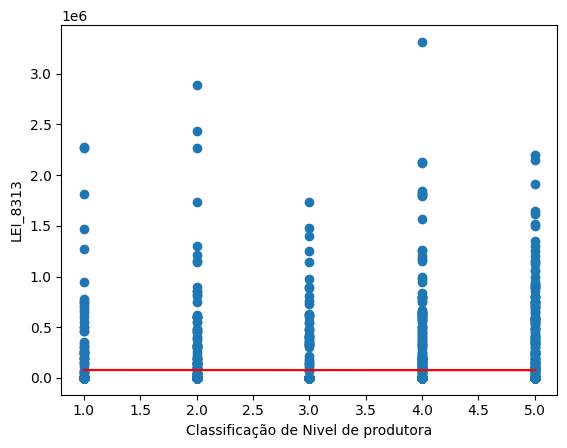

In [35]:
linear_regression_renuncia_fiscal(renuncia_fiscal_numerical['LEI_8313'])

In [36]:
#Linear Regression for Renúncia fiscal dataset - Total Captado
def linear_regression_renuncia_fiscal_2(y):

    X = renuncia_fiscal_numerical[['TOTAL_CAPTADO']]

    lin_reg = lm.LinearRegression()
    lin_reg.fit(X,y)
    ypred = lin_reg.predict(X)

    ypred = lin_reg.predict(X)
    print('Dependent Variable:', y.name)
    print('Coefficient', lin_reg.coef_)
    print('Intercept', lin_reg.intercept_)
    print('MSQERR', msqerr(y, ypred))
    print('R2', lin_reg.score(X,y))

    plt.figure()
    plt.scatter(X,y)
    plt.plot(X, ypred, color='red')
    plt.xlabel('TOTAL_CAPTADO')
    plt.ylabel(y.name)

Dependent Variable: CLASSIFICACAO_NIVEL_PRODUTORA
Coefficient [2.07933073e-07]
Intercept 3.2327775336198505
MSQERR 1.9629712025701478
R2 0.057911865242113225


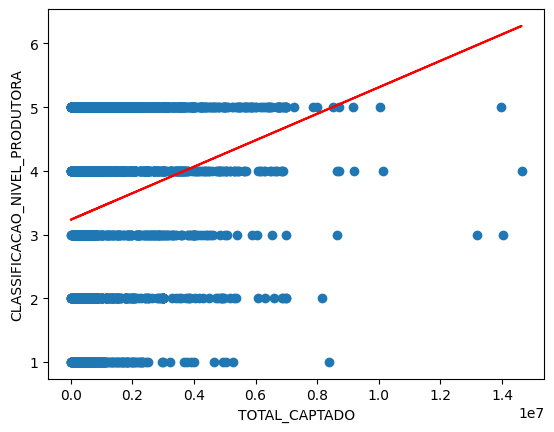

In [37]:
linear_regression_renuncia_fiscal_2(renuncia_fiscal_numerical['CLASSIFICACAO_NIVEL_PRODUTORA'])

---

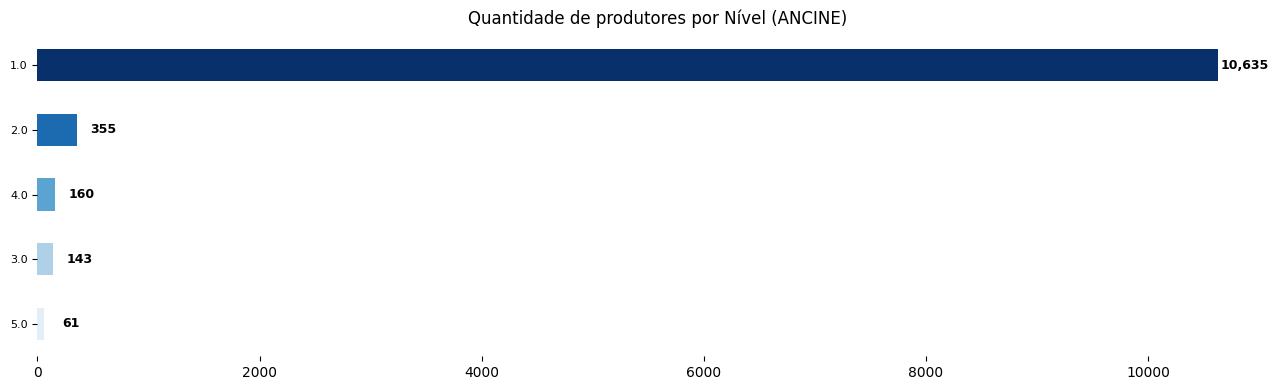

In [38]:
nivel_produtora_5 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 5.0]
nivel_produtora_4 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 4.0]
nivel_produtora_3 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 3.0]

nivel_produtora = agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'].value_counts()
plt.figure(figsize=(13,4))
cores = plt.cm.Blues(np.linspace(0.1, 1, len(nivel_produtora)))
ax = nivel_produtora.sort_values(ascending=True).plot(kind='barh', color=cores)

for n in ax.patches:
        ax.annotate(format(n.get_width(), ',.0f'),
                (n.get_width(), n.get_y() + n.get_height() / 2.),
                ha='center', va='center',
                xytext=(19, 0),
                textcoords='offset points',
                fontsize=9, fontweight='bold')
        
plt.ylabel(None)
plt.title('Quantidade de produtores por Nível (ANCINE)')
plt.yticks(fontsize=8)
plt.box(False)
plt.tight_layout()
plt.show()